<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=80, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=80, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


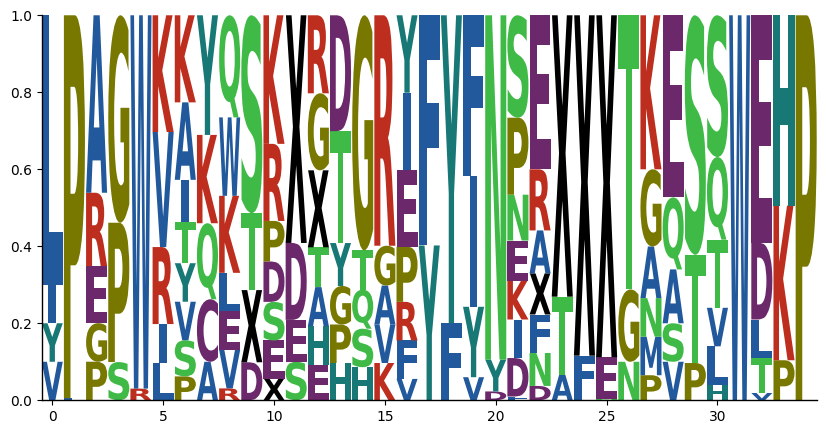

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,2500, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10


Epoch 1/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1000: 100%|██████████| 10/10 [00:01<00:00,  6.04samples/s]

Epoch 1/1000: 100%|██████████| 10/10 [00:01<00:00,  6.04samples/s, loss=973.736572265625]

Epoch 1/1000: 100%|██████████| 10/10 [00:01<00:00,  5.66samples/s, loss=973.736572265625]

Epoch 2/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 2/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 2/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=986.8714599609375]

Epoch 2/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=986.8714599609375]

Epoch 3/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 3/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 3/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=972.107666015625]

Epoch 3/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=972.107666015625]

Epoch 4/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 4/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 4/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1008.5550537109375]

Epoch 4/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=1008.5550537109375]

Epoch 5/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 5/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 5/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1000.4385986328125]

Epoch 5/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1000.4385986328125]

Epoch 6/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 6/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 6/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=979.64892578125]

Epoch 6/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=979.64892578125]

Epoch 7/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 7/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 7/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=973.498291015625]

Epoch 7/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=973.498291015625]

Epoch 8/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 8/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 8/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=965.10205078125]

Epoch 8/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=965.10205078125]

Epoch 9/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 9/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 9/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=987.818603515625]

Epoch 9/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=987.818603515625]

Epoch 10/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 10/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 10/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=998.2184448242188]

Epoch 10/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=998.2184448242188]

Epoch 11/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 11/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 11/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=984.1331787109375]

Epoch 11/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=984.1331787109375]

Epoch 12/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 12/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 12/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=987.7754516601562]

Epoch 12/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=987.7754516601562]

Epoch 13/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 13/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 13/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1006.80224609375]

Epoch 13/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1006.80224609375]

Epoch 14/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 14/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 14/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=977.2511596679688]

Epoch 14/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=977.2511596679688]

Epoch 15/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 15/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 15/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=942.4888305664062]

Epoch 15/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=942.4888305664062]

Epoch 16/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 16/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 16/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=972.0081176757812]

Epoch 16/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=972.0081176757812]

Epoch 17/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 17/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 17/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=936.0827026367188]

Epoch 17/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=936.0827026367188]

Epoch 18/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 18/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 18/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=971.4702758789062]

Epoch 18/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=971.4702758789062]

Epoch 19/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 19/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 19/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=974.6342163085938]

Epoch 19/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=974.6342163085938]

Epoch 20/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 20/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 20/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1007.248046875]

Epoch 20/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1007.248046875]

Epoch 21/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 21/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 21/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=964.4161987304688]

Epoch 21/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=964.4161987304688]

Epoch 22/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 22/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 22/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=979.6724853515625]

Epoch 22/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=979.6724853515625]

Epoch 23/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 23/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 23/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=968.5742797851562]

Epoch 23/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=968.5742797851562]

Epoch 24/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 24/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 24/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=949.8818969726562]

Epoch 24/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=949.8818969726562]

Epoch 25/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 25/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 25/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=979.59619140625]

Epoch 25/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=979.59619140625]

Epoch 26/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 26/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 26/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=940.3037719726562]

Epoch 26/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=940.3037719726562]

Epoch 27/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 27/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 27/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=957.7705078125]

Epoch 27/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=957.7705078125]

Epoch 28/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 28/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]

Epoch 28/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=930.1974487304688]

Epoch 28/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=930.1974487304688]

Epoch 29/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 29/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 29/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=942.199462890625]

Epoch 29/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=942.199462890625]

Epoch 30/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 30/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 30/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=924.0177001953125]

Epoch 30/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=924.0177001953125]

Epoch 31/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 31/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 31/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=951.498046875]

Epoch 31/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=951.498046875]

Epoch 32/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 32/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 32/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=929.9732666015625]

Epoch 32/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=929.9732666015625]

Epoch 33/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 33/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 33/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=931.8965454101562]

Epoch 33/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=931.8965454101562]

Epoch 34/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 34/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 34/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=939.4649047851562]

Epoch 34/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=939.4649047851562]

Epoch 35/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 35/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 35/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=941.0285034179688]

Epoch 35/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=941.0285034179688]

Epoch 36/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 36/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 36/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=920.8993530273438]

Epoch 36/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=920.8993530273438]

Epoch 37/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 37/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 37/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=908.18505859375]

Epoch 37/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=908.18505859375]

Epoch 38/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 38/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 38/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=918.7158203125]

Epoch 38/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=918.7158203125]

Epoch 39/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 39/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 39/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=928.4345092773438]

Epoch 39/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=928.4345092773438]

Epoch 40/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 40/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 40/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=916.4171142578125]

Epoch 40/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=916.4171142578125]

Epoch 41/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 41/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 41/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=936.3887939453125]

Epoch 41/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=936.3887939453125]

Epoch 42/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 42/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 42/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=956.7666015625]

Epoch 42/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=956.7666015625]

Epoch 43/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 43/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 43/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=953.1049194335938]

Epoch 43/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=953.1049194335938]

Epoch 44/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 44/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 44/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=919.958984375]

Epoch 44/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=919.958984375]

Epoch 45/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 45/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 45/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=933.521728515625]

Epoch 45/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=933.521728515625]

Epoch 46/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 46/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 46/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=970.7345581054688]

Epoch 46/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=970.7345581054688]

Epoch 47/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 47/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 47/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=932.4937133789062]

Epoch 47/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=932.4937133789062]

Epoch 48/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 48/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 48/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=925.1192016601562]

Epoch 48/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=925.1192016601562]

Epoch 49/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 49/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 49/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=922.8110961914062]

Epoch 49/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=922.8110961914062]

Epoch 50/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 50/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 50/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=923.5497436523438]

Epoch 50/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=923.5497436523438]

Epoch 51/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 51/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 51/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=894.1538696289062]

Epoch 51/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=894.1538696289062]

Epoch 52/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 52/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 52/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=908.275390625]

Epoch 52/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=908.275390625]

Epoch 53/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 53/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 53/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=912.309326171875]

Epoch 53/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=912.309326171875]

Epoch 54/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 54/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 54/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=897.2196044921875]

Epoch 54/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=897.2196044921875]

Epoch 55/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 55/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 55/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=899.3070678710938]

Epoch 55/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=899.3070678710938]

Epoch 56/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 56/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 56/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=906.0278930664062]

Epoch 56/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=906.0278930664062]

Epoch 57/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 57/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 57/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=893.599609375]

Epoch 57/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=893.599609375]

Epoch 58/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 58/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 58/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=898.8675537109375]

Epoch 58/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=898.8675537109375]

Epoch 59/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 59/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 59/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=892.495849609375]

Epoch 59/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=892.495849609375]

Epoch 60/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 60/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 60/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=905.0795288085938]

Epoch 60/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=905.0795288085938]

Epoch 61/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 61/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 61/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=891.93115234375]

Epoch 61/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=891.93115234375]

Epoch 62/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 62/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 62/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=908.5775146484375]

Epoch 62/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=908.5775146484375]

Epoch 63/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 63/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]

Epoch 63/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=888.839111328125]

Epoch 63/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=888.839111328125]

Epoch 64/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 64/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 64/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=894.4957275390625]

Epoch 64/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=894.4957275390625]

Epoch 65/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 65/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 65/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=895.9813842773438]

Epoch 65/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=895.9813842773438]

Epoch 66/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 66/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 66/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=888.035888671875]

Epoch 66/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=888.035888671875]

Epoch 67/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 67/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 67/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=882.4658203125]

Epoch 67/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=882.4658203125]

Epoch 68/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 68/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 68/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=888.7297973632812]

Epoch 68/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=888.7297973632812]

Epoch 69/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 69/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 69/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=887.9639282226562]

Epoch 69/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=887.9639282226562]

Epoch 70/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 70/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 70/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=890.6140747070312]

Epoch 70/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=890.6140747070312]

Epoch 71/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 71/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 71/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=885.1290893554688]

Epoch 71/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=885.1290893554688]

Epoch 72/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 72/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 72/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=878.5726928710938]

Epoch 72/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=878.5726928710938]

Epoch 73/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 73/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 73/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=891.690185546875]

Epoch 73/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=891.690185546875]

Epoch 74/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 74/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 74/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=887.7564086914062]

Epoch 74/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=887.7564086914062]

Epoch 75/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 75/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 75/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=885.251953125]

Epoch 75/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=885.251953125]

Epoch 76/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 76/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 76/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=885.7095336914062]

Epoch 76/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=885.7095336914062]

Epoch 77/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 77/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 77/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=877.4686889648438]

Epoch 77/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=877.4686889648438]

Epoch 78/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 78/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 78/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=869.7276611328125]

Epoch 78/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=869.7276611328125]

Epoch 79/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 79/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 79/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=873.828857421875]

Epoch 79/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=873.828857421875]

Epoch 80/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 80/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 80/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=872.2486572265625]

Epoch 80/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=872.2486572265625]

Epoch 81/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 81/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 81/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=881.2041625976562]

Epoch 81/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=881.2041625976562]

Epoch 82/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 82/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 82/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=880.5293579101562]

Epoch 82/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=880.5293579101562]

Epoch 83/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 83/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 83/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=864.2222290039062]

Epoch 83/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=864.2222290039062]

Epoch 84/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 84/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 84/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=869.27783203125]

Epoch 84/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=869.27783203125]

Epoch 85/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 85/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 85/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=862.9422607421875]

Epoch 85/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=862.9422607421875]

Epoch 86/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 86/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 86/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=857.0618286132812]

Epoch 86/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=857.0618286132812]

Epoch 87/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 87/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 87/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=859.6796875]

Epoch 87/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=859.6796875]

Epoch 88/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 88/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 88/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=865.6755981445312]

Epoch 88/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=865.6755981445312]

Epoch 89/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 89/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 89/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=851.363525390625]

Epoch 89/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=851.363525390625]

Epoch 90/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 90/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 90/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=854.9879760742188]

Epoch 90/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=854.9879760742188]

Epoch 91/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 91/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 91/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=852.3809814453125]

Epoch 91/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=852.3809814453125]

Epoch 92/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 92/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 92/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=845.4326171875]

Epoch 92/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=845.4326171875]

Epoch 93/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 93/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 93/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=849.6969604492188]

Epoch 93/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=849.6969604492188]

Epoch 94/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 94/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 94/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=848.425537109375]

Epoch 94/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=848.425537109375]

Epoch 95/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 95/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 95/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=846.893310546875]

Epoch 95/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=846.893310546875]

Epoch 96/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 96/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 96/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=862.9124755859375]

Epoch 96/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=862.9124755859375]

Epoch 97/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 97/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 97/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=847.3482055664062]

Epoch 97/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=847.3482055664062]

Epoch 98/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 98/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 98/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=845.2009887695312]

Epoch 98/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=845.2009887695312]

Epoch 99/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 99/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 99/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=851.953857421875]

Epoch 99/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=851.953857421875]

Epoch 100/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 100/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 100/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=850.7664794921875]

Epoch 100/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=850.7664794921875]

Epoch 101/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 101/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 101/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=850.0369873046875]

Epoch 101/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=850.0369873046875]

Epoch 102/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 102/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 102/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=847.4761352539062]

Epoch 102/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=847.4761352539062]

Epoch 103/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 103/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 103/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=855.0556640625]

Epoch 103/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=855.0556640625]

Epoch 104/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 104/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 104/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=845.3240356445312]

Epoch 104/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=845.3240356445312]

Epoch 105/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 105/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 105/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=846.2984008789062]

Epoch 105/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=846.2984008789062]

Epoch 106/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 106/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 106/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=856.3639526367188]

Epoch 106/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=856.3639526367188]

Epoch 107/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 107/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 107/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=849.4360961914062]

Epoch 107/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=849.4360961914062]

Epoch 108/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 108/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 108/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=843.0103149414062]

Epoch 108/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=843.0103149414062]

Epoch 109/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 109/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 109/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=849.0377197265625]

Epoch 109/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=849.0377197265625]

Epoch 110/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 110/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 110/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=845.0576782226562]

Epoch 110/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=845.0576782226562]

Epoch 111/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 111/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 111/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=837.1093139648438]

Epoch 111/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=837.1093139648438]

Epoch 112/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 112/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 112/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=839.7108764648438]

Epoch 112/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=839.7108764648438]

Epoch 113/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 113/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 113/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=832.3429565429688]

Epoch 113/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=832.3429565429688]

Epoch 114/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 114/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 114/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=844.5999755859375]

Epoch 114/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=844.5999755859375]

Epoch 115/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 115/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 115/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=834.8540649414062]

Epoch 115/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=834.8540649414062]

Epoch 116/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 116/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 116/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=831.6309204101562]

Epoch 116/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=831.6309204101562]

Epoch 117/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 117/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 117/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=832.5503540039062]

Epoch 117/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=832.5503540039062]

Epoch 118/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 118/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 118/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=835.1187744140625]

Epoch 118/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=835.1187744140625]

Epoch 119/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 119/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 119/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=842.5844116210938]

Epoch 119/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=842.5844116210938]

Epoch 120/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 120/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 120/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=838.346923828125]

Epoch 120/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=838.346923828125]

Epoch 121/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 121/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 121/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=831.460693359375]

Epoch 121/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=831.460693359375]

Epoch 122/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 122/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 122/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=834.59326171875]

Epoch 122/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=834.59326171875]

Epoch 123/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 123/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 123/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=835.0201416015625]

Epoch 123/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=835.0201416015625]

Epoch 124/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 124/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 124/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=830.4121704101562]

Epoch 124/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=830.4121704101562]

Epoch 125/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 125/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]

Epoch 125/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=837.581787109375]

Epoch 125/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=837.581787109375]

Epoch 126/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 126/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]

Epoch 126/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=832.2207641601562]

Epoch 126/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=832.2207641601562]

Epoch 127/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 127/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 127/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=836.077880859375]

Epoch 127/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=836.077880859375]

Epoch 128/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 128/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 128/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=837.7830200195312]

Epoch 128/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=837.7830200195312]

Epoch 129/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 129/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 129/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=841.4615478515625]

Epoch 129/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=841.4615478515625]

Epoch 130/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 130/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 130/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=833.7734985351562]

Epoch 130/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=833.7734985351562]

Epoch 131/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 131/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 131/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=834.6834716796875]

Epoch 131/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=834.6834716796875]

Epoch 132/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 132/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 132/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=827.7654418945312]

Epoch 132/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=827.7654418945312]

Epoch 133/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 133/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 133/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=835.0072631835938]

Epoch 133/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=835.0072631835938]

Epoch 134/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 134/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 134/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=818.52392578125]

Epoch 134/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=818.52392578125]

Epoch 135/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 135/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 135/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=826.6688232421875]

Epoch 135/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=826.6688232421875]

Epoch 136/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 136/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 136/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=826.9614868164062]

Epoch 136/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=826.9614868164062]

Epoch 137/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 137/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 137/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=834.13818359375]

Epoch 137/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=834.13818359375]

Epoch 138/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 138/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 138/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=820.146240234375]

Epoch 138/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=820.146240234375]

Epoch 139/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 139/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 139/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=823.6192016601562]

Epoch 139/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=823.6192016601562]

Epoch 140/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 140/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 140/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=825.116455078125]

Epoch 140/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=825.116455078125]

Epoch 141/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 141/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 141/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=826.458251953125]

Epoch 141/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=826.458251953125]

Epoch 142/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 142/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 142/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=815.42333984375]

Epoch 142/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=815.42333984375]

Epoch 143/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 143/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 143/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=824.0520629882812]

Epoch 143/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=824.0520629882812]

Epoch 144/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 144/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 144/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=829.9699096679688]

Epoch 144/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=829.9699096679688]

Epoch 145/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 145/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 145/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=827.8936157226562]

Epoch 145/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=827.8936157226562]

Epoch 146/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 146/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 146/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=815.3585205078125]

Epoch 146/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=815.3585205078125]

Epoch 147/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 147/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 147/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=828.6812133789062]

Epoch 147/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=828.6812133789062]

Epoch 148/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 148/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 148/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=813.5342407226562]

Epoch 148/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=813.5342407226562]

Epoch 149/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 149/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 149/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=829.2689819335938]

Epoch 149/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=829.2689819335938]

Epoch 150/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 150/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 150/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=825.750732421875]

Epoch 150/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=825.750732421875]

Epoch 151/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 151/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 151/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=815.4872436523438]

Epoch 151/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=815.4872436523438]

Epoch 152/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 152/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 152/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=827.1539916992188]

Epoch 152/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=827.1539916992188]

Epoch 153/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 153/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 153/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=819.7569580078125]

Epoch 153/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=819.7569580078125]

Epoch 154/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 154/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 154/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=814.7628784179688]

Epoch 154/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=814.7628784179688]

Epoch 155/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 155/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 155/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=816.5147705078125]

Epoch 155/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=816.5147705078125]

Epoch 156/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 156/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 156/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=814.1593017578125]

Epoch 156/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=814.1593017578125]

Epoch 157/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 157/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 157/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=826.93408203125]

Epoch 157/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=826.93408203125]

Epoch 158/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 158/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 158/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=812.080810546875]

Epoch 158/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=812.080810546875]

Epoch 159/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 159/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 159/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=816.9635620117188]

Epoch 159/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=816.9635620117188]

Epoch 160/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 160/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 160/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=811.2344360351562]

Epoch 160/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=811.2344360351562]

Epoch 161/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 161/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 161/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=812.807861328125]

Epoch 161/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=812.807861328125]

Epoch 162/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 162/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]

Epoch 162/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=821.5968627929688]

Epoch 162/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=821.5968627929688]

Epoch 163/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 163/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 163/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=824.4201049804688]

Epoch 163/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=824.4201049804688]

Epoch 164/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 164/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 164/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=815.650634765625]

Epoch 164/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=815.650634765625]

Epoch 165/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 165/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 165/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=812.30517578125]

Epoch 165/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=812.30517578125]

Epoch 166/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 166/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 166/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=817.7410888671875]

Epoch 166/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=817.7410888671875]

Epoch 167/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 167/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 167/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=811.9912719726562]

Epoch 167/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=811.9912719726562]

Epoch 168/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 168/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 168/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=826.3438720703125]

Epoch 168/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=826.3438720703125]

Epoch 169/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 169/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 169/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=817.3572387695312]

Epoch 169/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=817.3572387695312]

Epoch 170/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 170/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 170/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=822.8766479492188]

Epoch 170/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=822.8766479492188]

Epoch 171/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 171/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 171/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=853.138427734375]

Epoch 171/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=853.138427734375]

Epoch 172/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 172/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 172/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=819.98046875]

Epoch 172/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=819.98046875]

Epoch 173/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 173/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 173/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=848.1992797851562]

Epoch 173/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=848.1992797851562]

Epoch 174/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 174/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 174/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=816.0333862304688]

Epoch 174/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=816.0333862304688]

Epoch 175/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 175/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 175/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=846.119140625]

Epoch 175/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=846.119140625]

Epoch 176/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 176/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 176/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=816.0464477539062]

Epoch 176/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=816.0464477539062]

Epoch 177/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 177/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 177/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=838.43994140625]

Epoch 177/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=838.43994140625]

Epoch 178/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 178/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 178/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=817.3619995117188]

Epoch 178/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=817.3619995117188]

Epoch 179/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 179/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 179/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=829.9540405273438]

Epoch 179/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=829.9540405273438]

Epoch 180/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 180/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 180/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=816.7321166992188]

Epoch 180/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=816.7321166992188]

Epoch 181/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 181/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 181/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=824.9180908203125]

Epoch 181/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=824.9180908203125]

Epoch 182/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 182/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 182/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=813.6383056640625]

Epoch 182/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=813.6383056640625]

Epoch 183/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 183/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 183/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=822.2967529296875]

Epoch 183/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=822.2967529296875]

Epoch 184/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 184/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 184/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=819.4661254882812]

Epoch 184/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=819.4661254882812]

Epoch 185/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 185/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 185/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=818.518798828125]

Epoch 185/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=818.518798828125]

Epoch 186/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 186/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 186/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=836.761962890625]

Epoch 186/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=836.761962890625]

Epoch 187/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 187/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 187/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=811.7870483398438]

Epoch 187/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=811.7870483398438]

Epoch 188/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 188/1000: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 188/1000: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=817.0452880859375]

Epoch 188/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=817.0452880859375]

Epoch 189/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 189/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]

Epoch 189/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=816.0089111328125]

Epoch 189/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=816.0089111328125]

Epoch 190/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 190/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 190/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=821.2058715820312]

Epoch 190/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=821.2058715820312]

Epoch 191/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 191/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 191/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=822.1264038085938]

Epoch 191/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=822.1264038085938]

Epoch 192/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 192/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 192/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=823.105712890625]

Epoch 192/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=823.105712890625]

Epoch 193/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 193/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 193/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=813.2874755859375]

Epoch 193/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=813.2874755859375]

Epoch 194/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 194/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 194/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=815.4067993164062]

Epoch 194/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=815.4067993164062]

Epoch 195/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 195/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 195/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=818.2855224609375]

Epoch 195/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=818.2855224609375]

Epoch 196/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 196/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 196/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=821.2516479492188]

Epoch 196/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=821.2516479492188]

Epoch 197/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 197/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 197/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=809.7314453125]

Epoch 197/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=809.7314453125]

Epoch 198/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 198/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 198/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=814.1390991210938]

Epoch 198/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=814.1390991210938]

Epoch 199/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 199/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 199/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=822.8409423828125]

Epoch 199/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=822.8409423828125]

Epoch 200/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 200/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 200/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=821.720703125]

Epoch 200/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=821.720703125]

Epoch 201/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 201/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 201/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=818.2388916015625]

Epoch 201/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=818.2388916015625]

Epoch 202/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 202/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 202/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=816.4827270507812]

Epoch 202/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=816.4827270507812]

Epoch 203/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 203/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 203/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=817.3758544921875]

Epoch 203/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=817.3758544921875]

Epoch 204/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 204/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 204/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=818.5377197265625]

Epoch 204/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=818.5377197265625]

Epoch 205/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

From Here


Epoch 205/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 205/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=821.8888549804688]

Epoch 205/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=821.8888549804688]

Epoch 206/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 206/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 206/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=809.2147827148438]

Epoch 206/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=809.2147827148438]

Epoch 207/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 207/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 207/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=827.291015625]

Epoch 207/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=827.291015625]

Epoch 208/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 208/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 208/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=817.3486328125]

Epoch 208/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=817.3486328125]

Epoch 209/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 209/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 209/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=822.56689453125]

Epoch 209/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=822.56689453125]

Epoch 210/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 210/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 210/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=815.9747314453125]

Epoch 210/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=815.9747314453125]

Epoch 211/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 211/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 211/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=810.9088745117188]

Epoch 211/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=810.9088745117188]

Epoch 212/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 212/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 212/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=826.8534545898438]

Epoch 212/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=826.8534545898438]

Epoch 213/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 213/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 213/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.7250366210938]

Epoch 213/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=808.7250366210938]

Epoch 214/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 214/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 214/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=832.4683837890625]

Epoch 214/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=832.4683837890625]

Epoch 215/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 215/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 215/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=811.14697265625]

Epoch 215/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=811.14697265625]

Epoch 216/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 216/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 216/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=818.3739624023438]

Epoch 216/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=818.3739624023438]

Epoch 217/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 217/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 217/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=810.7250366210938]

Epoch 217/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=810.7250366210938]

Epoch 218/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 218/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 218/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=814.9083862304688]

Epoch 218/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=814.9083862304688]

Epoch 219/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 219/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 219/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=811.470458984375]

Epoch 219/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=811.470458984375]

Epoch 220/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 220/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 220/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=821.7166748046875]

Epoch 220/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=821.7166748046875]

Epoch 221/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 221/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 221/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=819.675537109375]

Epoch 221/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=819.675537109375]

Epoch 222/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 222/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 222/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=816.1768188476562]

Epoch 222/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=816.1768188476562]

Epoch 223/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 223/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 223/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=816.8173828125]

Epoch 223/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=816.8173828125]

Epoch 224/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 224/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 224/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=814.5257568359375]

Epoch 224/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=814.5257568359375]

Epoch 225/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 225/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 225/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=815.8426513671875]

Epoch 225/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=815.8426513671875]

Epoch 226/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 226/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 226/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=813.1947631835938]

Epoch 226/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=813.1947631835938]

Epoch 227/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 227/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 227/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=840.3440551757812]

Epoch 227/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=840.3440551757812]

Epoch 228/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 228/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 228/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=815.5797729492188]

Epoch 228/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=815.5797729492188]

Epoch 229/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 229/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 229/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=821.7269897460938]

Epoch 229/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=821.7269897460938]

Epoch 230/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 230/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 230/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=809.5204467773438]

Epoch 230/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=809.5204467773438]

Epoch 231/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 231/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 231/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=819.3475952148438]

Epoch 231/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=819.3475952148438]

Epoch 232/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 232/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 232/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=814.5921020507812]

Epoch 232/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=814.5921020507812]

Epoch 233/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 233/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 233/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=813.5070190429688]

Epoch 233/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=813.5070190429688]

Epoch 234/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 234/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 234/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=817.6328125]

Epoch 234/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=817.6328125]

Epoch 235/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 235/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 235/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=812.2828979492188]

Epoch 235/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=812.2828979492188]

Epoch 236/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 236/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 236/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=819.1928100585938]

Epoch 236/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=819.1928100585938]

Epoch 237/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 237/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 237/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=807.53173828125]

Epoch 237/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=807.53173828125]

Epoch 238/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 238/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 238/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=823.0979614257812]

Epoch 238/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=823.0979614257812]

Epoch 239/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 239/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 239/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=809.458740234375]

Epoch 239/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=809.458740234375]

Epoch 240/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 240/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 240/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=815.06884765625]

Epoch 240/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=815.06884765625]

Epoch 241/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 241/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 241/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.4510498046875]

Epoch 241/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=807.4510498046875]

Epoch 242/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 242/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 242/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=811.803955078125]

Epoch 242/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=811.803955078125]

Epoch 243/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 243/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 243/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=813.2052001953125]

Epoch 243/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=813.2052001953125]

Epoch 244/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 244/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 244/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=806.6474609375]

Epoch 244/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=806.6474609375]

Epoch 245/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 245/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 245/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=812.0501098632812]

Epoch 245/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=812.0501098632812]

Epoch 246/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 246/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 246/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=808.5411987304688]

Epoch 246/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=808.5411987304688]

Epoch 247/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 247/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 247/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=825.0269775390625]

Epoch 247/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=825.0269775390625]

Epoch 248/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 248/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 248/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=806.2355346679688]

Epoch 248/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=806.2355346679688]

Epoch 249/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 249/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 249/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=812.7637329101562]

Epoch 249/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=812.7637329101562]

Epoch 250/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 250/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 250/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=810.7622680664062]

Epoch 250/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=810.7622680664062]

Epoch 251/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 251/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 251/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=810.288330078125]

Epoch 251/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=810.288330078125]

Epoch 252/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 252/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 252/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=812.146240234375]

Epoch 252/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=812.146240234375]

Epoch 253/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 253/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 253/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.1759643554688]

Epoch 253/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.1759643554688]

Epoch 254/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 254/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 254/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=823.8192138671875]

Epoch 254/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=823.8192138671875]

Epoch 255/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 255/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 255/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.075439453125]

Epoch 255/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=808.075439453125]

Epoch 256/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 256/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 256/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=819.6212158203125]

Epoch 256/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=819.6212158203125]

Epoch 257/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 257/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 257/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.7081909179688]

Epoch 257/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=807.7081909179688]

Epoch 258/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 258/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 258/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=817.1386108398438]

Epoch 258/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=817.1386108398438]

Epoch 259/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 259/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 259/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.0517578125]

Epoch 259/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.0517578125]

Epoch 260/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 260/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 260/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=815.9072265625]

Epoch 260/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=815.9072265625]

Epoch 261/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 261/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 261/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=814.4021606445312]

Epoch 261/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=814.4021606445312]

Epoch 262/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 262/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 262/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=815.3641357421875]

Epoch 262/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=815.3641357421875]

Epoch 263/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 263/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 263/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=816.5939331054688]

Epoch 263/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=816.5939331054688]

Epoch 264/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 264/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 264/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=809.5364990234375]

Epoch 264/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=809.5364990234375]

Epoch 265/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 265/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 265/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=816.953125]

Epoch 265/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=816.953125]

Epoch 266/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 266/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 266/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.7682495117188]

Epoch 266/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=806.7682495117188]

Epoch 267/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 267/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 267/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=815.9954833984375]

Epoch 267/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=815.9954833984375]

Epoch 268/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 268/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 268/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=815.7308959960938]

Epoch 268/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=815.7308959960938]

Epoch 269/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 269/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 269/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=817.859619140625]

Epoch 269/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=817.859619140625]

Epoch 270/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 270/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 270/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.8320922851562]

Epoch 270/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=806.8320922851562]

Epoch 271/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 271/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 271/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=809.5680541992188]

Epoch 271/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=809.5680541992188]

Epoch 272/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 272/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 272/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.474365234375]

Epoch 272/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=808.474365234375]

Epoch 273/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 273/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 273/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.228759765625]

Epoch 273/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.228759765625]

Epoch 274/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 274/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 274/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=812.0574340820312]

Epoch 274/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=812.0574340820312]

Epoch 275/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 275/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 275/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=809.1550903320312]

Epoch 275/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=809.1550903320312]

Epoch 276/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 276/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 276/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=818.8435668945312]

Epoch 276/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=818.8435668945312]

Epoch 277/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 277/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 277/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=808.1572265625]

Epoch 277/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=808.1572265625]

Epoch 278/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 278/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 278/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=817.8710327148438]

Epoch 278/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=817.8710327148438]

Epoch 279/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 279/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 279/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=809.898193359375]

Epoch 279/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=809.898193359375]

Epoch 280/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 280/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 280/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=819.2083129882812]

Epoch 280/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=819.2083129882812]

Epoch 281/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 281/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 281/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=822.431884765625]

Epoch 281/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=822.431884765625]

Epoch 282/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 282/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 282/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=808.0594482421875]

Epoch 282/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=808.0594482421875]

Epoch 283/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 283/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 283/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=815.9315185546875]

Epoch 283/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=815.9315185546875]

Epoch 284/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 284/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 284/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=807.3202514648438]

Epoch 284/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=807.3202514648438]

Epoch 285/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 285/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 285/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=812.7236328125]

Epoch 285/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=812.7236328125]

Epoch 286/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 286/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 286/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=806.212890625]

Epoch 286/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=806.212890625]

Epoch 287/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 287/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 287/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=814.2598266601562]

Epoch 287/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=814.2598266601562]

Epoch 288/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 288/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 288/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=809.5904541015625]

Epoch 288/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=809.5904541015625]

Epoch 289/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 289/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 289/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=808.1712036132812]

Epoch 289/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=808.1712036132812]

Epoch 290/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 290/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 290/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=805.3517456054688]

Epoch 290/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=805.3517456054688]

Epoch 291/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 291/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 291/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=806.3197631835938]

Epoch 291/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=806.3197631835938]

Epoch 292/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 292/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 292/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=807.0260009765625]

Epoch 292/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=807.0260009765625]

Epoch 293/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 293/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 293/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=808.1156616210938]

Epoch 293/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=808.1156616210938]

Epoch 294/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 294/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 294/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=805.0281372070312]

Epoch 294/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=805.0281372070312]

Epoch 295/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 295/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 295/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=804.9052734375]

Epoch 295/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=804.9052734375]

Epoch 296/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 296/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 296/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=806.9624633789062]

Epoch 296/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=806.9624633789062]

Epoch 297/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 297/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 297/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=805.2357177734375]

Epoch 297/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=805.2357177734375]

Epoch 298/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 298/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 298/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.9959716796875]

Epoch 298/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=804.9959716796875]

Epoch 299/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 299/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 299/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=805.2741088867188]

Epoch 299/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=805.2741088867188]

Epoch 300/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 300/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 300/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=805.7255859375]

Epoch 300/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=805.7255859375]

Epoch 301/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 301/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 301/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.7503051757812]

Epoch 301/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=805.7503051757812]

Epoch 302/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 302/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 302/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.6739501953125]

Epoch 302/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=805.6739501953125]

Epoch 303/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 303/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 303/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=806.5457153320312]

Epoch 303/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=806.5457153320312]

Epoch 304/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 304/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 304/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=808.51318359375]

Epoch 304/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=808.51318359375]

Epoch 305/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 305/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 305/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=807.4842529296875]

Epoch 305/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=807.4842529296875]

Epoch 306/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 306/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 306/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=807.1656494140625]

Epoch 306/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=807.1656494140625]

Epoch 307/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 307/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 307/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=813.5437622070312]

Epoch 307/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=813.5437622070312]

Epoch 308/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 308/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 308/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=810.3937377929688]

Epoch 308/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=810.3937377929688]

Epoch 309/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 309/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 309/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=808.557861328125]

Epoch 309/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.557861328125]

Epoch 310/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 310/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 310/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.9527587890625]

Epoch 310/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=807.9527587890625]

Epoch 311/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 311/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 311/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=810.9933471679688]

Epoch 311/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=810.9933471679688]

Epoch 312/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 312/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 312/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=808.9812622070312]

Epoch 312/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=808.9812622070312]

Epoch 313/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 313/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 313/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=805.888427734375]

Epoch 313/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=805.888427734375]

Epoch 314/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 314/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]

Epoch 314/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=807.923828125]

Epoch 314/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=807.923828125]

Epoch 315/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 315/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 315/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=806.6257934570312]

Epoch 315/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=806.6257934570312]

Epoch 316/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 316/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 316/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.0508422851562]

Epoch 316/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=805.0508422851562]

Epoch 317/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 317/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 317/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=811.136474609375]

Epoch 317/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=811.136474609375]

Epoch 318/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 318/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 318/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.8992309570312]

Epoch 318/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=807.8992309570312]

Epoch 319/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 319/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 319/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=810.6903076171875]

Epoch 319/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=810.6903076171875]

Epoch 320/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 320/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 320/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=810.728515625]

Epoch 320/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=810.728515625]

Epoch 321/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 321/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 321/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=815.1209106445312]

Epoch 321/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=815.1209106445312]

Epoch 322/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 322/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 322/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=805.7648315429688]

Epoch 322/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=805.7648315429688]

Epoch 323/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 323/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 323/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=809.679443359375]

Epoch 323/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=809.679443359375]

Epoch 324/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 324/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 324/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=816.6861572265625]

Epoch 324/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=816.6861572265625]

Epoch 325/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 325/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 325/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.572265625]

Epoch 325/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=806.572265625]

Epoch 326/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 326/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 326/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=810.0795288085938]

Epoch 326/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=810.0795288085938]

Epoch 327/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 327/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 327/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.553955078125]

Epoch 327/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=806.553955078125]

Epoch 328/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 328/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 328/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.270751953125]

Epoch 328/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=806.270751953125]

Epoch 329/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 329/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 329/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=807.2529907226562]

Epoch 329/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=807.2529907226562]

Epoch 330/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 330/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 330/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.9641723632812]

Epoch 330/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=807.9641723632812]

Epoch 331/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 331/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 331/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=804.0030517578125]

Epoch 331/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=804.0030517578125]

Epoch 332/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 332/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 332/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=807.4285278320312]

Epoch 332/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=807.4285278320312]

Epoch 333/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 333/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 333/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=806.8065185546875]

Epoch 333/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=806.8065185546875]

Epoch 334/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 334/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 334/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=804.825927734375]

Epoch 334/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=804.825927734375]

Epoch 335/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 335/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 335/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=804.7635498046875]

Epoch 335/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=804.7635498046875]

Epoch 336/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 336/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 336/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=806.6911010742188]

Epoch 336/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=806.6911010742188]

Epoch 337/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 337/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 337/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=804.1548461914062]

Epoch 337/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=804.1548461914062]

Epoch 338/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 338/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 338/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.9299926757812]

Epoch 338/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=803.9299926757812]

Epoch 339/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 339/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 339/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=804.5720825195312]

Epoch 339/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=804.5720825195312]

Epoch 340/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 340/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 340/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=804.2349853515625]

Epoch 340/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=804.2349853515625]

Epoch 341/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 341/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 341/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.4476318359375]

Epoch 341/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=805.4476318359375]

Epoch 342/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 342/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 342/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.4524536132812]

Epoch 342/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=806.4524536132812]

Epoch 343/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 343/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 343/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=804.1820068359375]

Epoch 343/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=804.1820068359375]

Epoch 344/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 344/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 344/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=803.045654296875]

Epoch 344/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=803.045654296875]

Epoch 345/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 345/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 345/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.3408813476562]

Epoch 345/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=803.3408813476562]

Epoch 346/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 346/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 346/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.8978881835938]

Epoch 346/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.8978881835938]

Epoch 347/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 347/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 347/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=804.8751220703125]

Epoch 347/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=804.8751220703125]

Epoch 348/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 348/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 348/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=802.9302978515625]

Epoch 348/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=802.9302978515625]

Epoch 349/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 349/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 349/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.3555908203125]

Epoch 349/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=805.3555908203125]

Epoch 350/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 350/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 350/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=805.1004028320312]

Epoch 350/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=805.1004028320312]

Epoch 351/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 351/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 351/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.94580078125]

Epoch 351/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=802.94580078125]

Epoch 352/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 352/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 352/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=818.7518920898438]

Epoch 352/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=818.7518920898438]

Epoch 353/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 353/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 353/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=809.0292358398438]

Epoch 353/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=809.0292358398438]

Epoch 354/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 354/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 354/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=806.3616943359375]

Epoch 354/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=806.3616943359375]

Epoch 355/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 355/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 355/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=809.3124389648438]

Epoch 355/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=809.3124389648438]

Epoch 356/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 356/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 356/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.581787109375]

Epoch 356/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=802.581787109375]

Epoch 357/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 357/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 357/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=811.6842041015625]

Epoch 357/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=811.6842041015625]

Epoch 358/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 358/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 358/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=805.1098022460938]

Epoch 358/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=805.1098022460938]

Epoch 359/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 359/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 359/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=811.4501953125]

Epoch 359/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=811.4501953125]

Epoch 360/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 360/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 360/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=811.5551147460938]

Epoch 360/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=811.5551147460938]

Epoch 361/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 361/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 361/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=810.2241821289062]

Epoch 361/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=810.2241821289062]

Epoch 362/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 362/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 362/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=817.3179321289062]

Epoch 362/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=817.3179321289062]

Epoch 363/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 363/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 363/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=803.939208984375]

Epoch 363/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=803.939208984375]

Epoch 364/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 364/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 364/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=812.4209594726562]

Epoch 364/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=812.4209594726562]

Epoch 365/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 365/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 365/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.4144287109375]

Epoch 365/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=802.4144287109375]

Epoch 366/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 366/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 366/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=809.87548828125]

Epoch 366/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=809.87548828125]

Epoch 367/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 367/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 367/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=804.9503173828125]

Epoch 367/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=804.9503173828125]

Epoch 368/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 368/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 368/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=806.0264892578125]

Epoch 368/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=806.0264892578125]

Epoch 369/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 369/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 369/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=809.2617797851562]

Epoch 369/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=809.2617797851562]

Epoch 370/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 370/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 370/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=809.6434936523438]

Epoch 370/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=809.6434936523438]

Epoch 371/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 371/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 371/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=805.3502197265625]

Epoch 371/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=805.3502197265625]

Epoch 372/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 372/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 372/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.8914184570312]

Epoch 372/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=802.8914184570312]

Epoch 373/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 373/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 373/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.76123046875]

Epoch 373/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.76123046875]

Epoch 374/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 374/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 374/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.7547607421875]

Epoch 374/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=802.7547607421875]

Epoch 375/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 375/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 375/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=803.0672607421875]

Epoch 375/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=803.0672607421875]

Epoch 376/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 376/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 376/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=808.7009887695312]

Epoch 376/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=808.7009887695312]

Epoch 377/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 377/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 377/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=804.9332885742188]

Epoch 377/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=804.9332885742188]

Epoch 378/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 378/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]

Epoch 378/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=812.3309326171875]

Epoch 378/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=812.3309326171875]

Epoch 379/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 379/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 379/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=805.1734619140625]

Epoch 379/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=805.1734619140625]

Epoch 380/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 380/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 380/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=804.9453125]

Epoch 380/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=804.9453125]

Epoch 381/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 381/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 381/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=805.0125732421875]

Epoch 381/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=805.0125732421875]

Epoch 382/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 382/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 382/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.8233032226562]

Epoch 382/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=805.8233032226562]

Epoch 383/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 383/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 383/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.307373046875]

Epoch 383/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=803.307373046875]

Epoch 384/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 384/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 384/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.3915405273438]

Epoch 384/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=807.3915405273438]

Epoch 385/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 385/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 385/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=806.2473754882812]

Epoch 385/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=806.2473754882812]

Epoch 386/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 386/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 386/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=804.6411743164062]

Epoch 386/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=804.6411743164062]

Epoch 387/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 387/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 387/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=810.9557495117188]

Epoch 387/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=810.9557495117188]

Epoch 388/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 388/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 388/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.5426025390625]

Epoch 388/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=804.5426025390625]

Epoch 389/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 389/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 389/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=819.7051391601562]

Epoch 389/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=819.7051391601562]

Epoch 390/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 390/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 390/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=804.2280883789062]

Epoch 390/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=804.2280883789062]

Epoch 391/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 391/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 391/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=810.1990356445312]

Epoch 391/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=810.1990356445312]

Epoch 392/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 392/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 392/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=806.3475952148438]

Epoch 392/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=806.3475952148438]

Epoch 393/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 393/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 393/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.0516357421875]

Epoch 393/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=807.0516357421875]

Epoch 394/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 394/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 394/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=804.4151000976562]

Epoch 394/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.4151000976562]

Epoch 395/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 395/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 395/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=813.43115234375]

Epoch 395/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=813.43115234375]

Epoch 396/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 396/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 396/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=806.3438720703125]

Epoch 396/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=806.3438720703125]

Epoch 397/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 397/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 397/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=808.2400512695312]

Epoch 397/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=808.2400512695312]

Epoch 398/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 398/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 398/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=812.1398315429688]

Epoch 398/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=812.1398315429688]

Epoch 399/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 399/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 399/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=812.418701171875]

Epoch 399/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=812.418701171875]

Epoch 400/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 400/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 400/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=817.38134765625]

Epoch 400/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=817.38134765625]

Epoch 401/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 401/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 401/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=807.2327880859375]

Epoch 401/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=807.2327880859375]

Epoch 402/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 402/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 402/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=823.8660888671875]

Epoch 402/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=823.8660888671875]

Epoch 403/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 403/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 403/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=807.2152099609375]

Epoch 403/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=807.2152099609375]

Epoch 404/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 404/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 404/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=818.4635620117188]

Epoch 404/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=818.4635620117188]

Epoch 405/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 405/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 405/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=815.8206176757812]

Epoch 405/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=815.8206176757812]

Epoch 406/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 406/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 406/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=824.4749145507812]

Epoch 406/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=824.4749145507812]

Epoch 407/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 407/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 407/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=816.8186645507812]

Epoch 407/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=816.8186645507812]

Epoch 408/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 408/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 408/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=808.4955444335938]

Epoch 408/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=808.4955444335938]

Epoch 409/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 409/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 409/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=814.9540405273438]

Epoch 409/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=814.9540405273438]

Epoch 410/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 410/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 410/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=814.4085693359375]

Epoch 410/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=814.4085693359375]

Epoch 411/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 411/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 411/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=814.9819946289062]

Epoch 411/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=814.9819946289062]

Epoch 412/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 412/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 412/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=804.1619262695312]

Epoch 412/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=804.1619262695312]

Epoch 413/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 413/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 413/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=816.751220703125]

Epoch 413/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=816.751220703125]

Epoch 414/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 414/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 414/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=809.3389892578125]

Epoch 414/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=809.3389892578125]

Epoch 415/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 415/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 415/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=809.1788940429688]

Epoch 415/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=809.1788940429688]

Epoch 416/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 416/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 416/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=806.8021850585938]

Epoch 416/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=806.8021850585938]

Epoch 417/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 417/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 417/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=806.7593994140625]

Epoch 417/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=806.7593994140625]

Epoch 418/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 418/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 418/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.034912109375]

Epoch 418/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.034912109375]

Epoch 419/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 419/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 419/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=807.8969116210938]

Epoch 419/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=807.8969116210938]

Epoch 420/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 420/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 420/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=807.8689575195312]

Epoch 420/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=807.8689575195312]

Epoch 421/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 421/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 421/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.3967895507812]

Epoch 421/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=804.3967895507812]

Epoch 422/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 422/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 422/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.9354248046875]

Epoch 422/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.9354248046875]

Epoch 423/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 423/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 423/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.6344604492188]

Epoch 423/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=802.6344604492188]

Epoch 424/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 424/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 424/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.433349609375]

Epoch 424/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=804.433349609375]

Epoch 425/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 425/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 425/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=804.0885620117188]

Epoch 425/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=804.0885620117188]

Epoch 426/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 426/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]

Epoch 426/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=804.1618041992188]

Epoch 426/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=804.1618041992188]

Epoch 427/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 427/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 427/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.2907104492188]

Epoch 427/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.2907104492188]

Epoch 428/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 428/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 428/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.1580810546875]

Epoch 428/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.1580810546875]

Epoch 429/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 429/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 429/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.3670043945312]

Epoch 429/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=802.3670043945312]

Epoch 430/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 430/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 430/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.9542236328125]

Epoch 430/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=803.9542236328125]

Epoch 431/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 431/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 431/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=807.50341796875]

Epoch 431/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=807.50341796875]

Epoch 432/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 432/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 432/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.7919311523438]

Epoch 432/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.7919311523438]

Epoch 433/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 433/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 433/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=806.6067504882812]

Epoch 433/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=806.6067504882812]

Epoch 434/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 434/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 434/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=801.8853149414062]

Epoch 434/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.8853149414062]

Epoch 435/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 435/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 435/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.8971557617188]

Epoch 435/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=803.8971557617188]

Epoch 436/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 436/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 436/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.801513671875]

Epoch 436/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.801513671875]

Epoch 437/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 437/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 437/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.8263549804688]

Epoch 437/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=802.8263549804688]

Epoch 438/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 438/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]

Epoch 438/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=803.63134765625]

Epoch 438/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=803.63134765625]

Epoch 439/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 439/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 439/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.8553466796875]

Epoch 439/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.8553466796875]

Epoch 440/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 440/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]

Epoch 440/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=803.0349731445312]

Epoch 440/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=803.0349731445312]

Epoch 441/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 441/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 441/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=801.4727172851562]

Epoch 441/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=801.4727172851562]

Epoch 442/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 442/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 442/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.2514038085938]

Epoch 442/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.2514038085938]

Epoch 443/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 443/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 443/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=805.148193359375]

Epoch 443/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=805.148193359375]

Epoch 444/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 444/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 444/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.7887573242188]

Epoch 444/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.7887573242188]

Epoch 445/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 445/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 445/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.2684326171875]

Epoch 445/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.2684326171875]

Epoch 446/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 446/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 446/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.3595581054688]

Epoch 446/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.3595581054688]

Epoch 447/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 447/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 447/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=806.7839965820312]

Epoch 447/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=806.7839965820312]

Epoch 448/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 448/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 448/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.3284301757812]

Epoch 448/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.3284301757812]

Epoch 449/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 449/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 449/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.4998168945312]

Epoch 449/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=801.4998168945312]

Epoch 450/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 450/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 450/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.0372314453125]

Epoch 450/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.0372314453125]

Epoch 451/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 451/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 451/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.0004272460938]

Epoch 451/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.0004272460938]

Epoch 452/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 452/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 452/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.5924072265625]

Epoch 452/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.5924072265625]

Epoch 453/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 453/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 453/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=804.4337768554688]

Epoch 453/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.4337768554688]

Epoch 454/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 454/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 454/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.7819213867188]

Epoch 454/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.7819213867188]

Epoch 455/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 455/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 455/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.526123046875]

Epoch 455/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.526123046875]

Epoch 456/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 456/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 456/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.557373046875]

Epoch 456/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=802.557373046875]

Epoch 457/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 457/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 457/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.9613037109375]

Epoch 457/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.9613037109375]

Epoch 458/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 458/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 458/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.2946166992188]

Epoch 458/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=802.2946166992188]

Epoch 459/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 459/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 459/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.6737060546875]

Epoch 459/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.6737060546875]

Epoch 460/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 460/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 460/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.1725463867188]

Epoch 460/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=802.1725463867188]

Epoch 461/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 461/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 461/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=801.9437866210938]

Epoch 461/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.9437866210938]

Epoch 462/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 462/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 462/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=801.4380493164062]

Epoch 462/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=801.4380493164062]

Epoch 463/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 463/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 463/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.0813598632812]

Epoch 463/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=805.0813598632812]

Epoch 464/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 464/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 464/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.5516967773438]

Epoch 464/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=802.5516967773438]

Epoch 465/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 465/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 465/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=801.2904052734375]

Epoch 465/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=801.2904052734375]

Epoch 466/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 466/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 466/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.4903564453125]

Epoch 466/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.4903564453125]

Epoch 467/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 467/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 467/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.1694946289062]

Epoch 467/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.1694946289062]

Epoch 468/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 468/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 468/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=800.0266723632812]

Epoch 468/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=800.0266723632812]

Epoch 469/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 469/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 469/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=802.0007934570312]

Epoch 469/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=802.0007934570312]

Epoch 470/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 470/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 470/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=801.6838989257812]

Epoch 470/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=801.6838989257812]

Epoch 471/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 471/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 471/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.3974609375]

Epoch 471/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=800.3974609375]

Epoch 472/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 472/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 472/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.9671020507812]

Epoch 472/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=803.9671020507812]

Epoch 473/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 473/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 473/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.0416870117188]

Epoch 473/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=801.0416870117188]

Epoch 474/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 474/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 474/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=804.54833984375]

Epoch 474/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.54833984375]

Epoch 475/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 475/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 475/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=802.321044921875]

Epoch 475/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=802.321044921875]

Epoch 476/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 476/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]

Epoch 476/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=802.01123046875]

Epoch 476/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=802.01123046875]

Epoch 477/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 477/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 477/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=805.2747192382812]

Epoch 477/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=805.2747192382812]

Epoch 478/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 478/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 478/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.1397705078125]

Epoch 478/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=802.1397705078125]

Epoch 479/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 479/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 479/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=804.3446655273438]

Epoch 479/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.3446655273438]

Epoch 480/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 480/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 480/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=801.5265502929688]

Epoch 480/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=801.5265502929688]

Epoch 481/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 481/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 481/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.7596435546875]

Epoch 481/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=804.7596435546875]

Epoch 482/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 482/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 482/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.5113525390625]

Epoch 482/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.5113525390625]

Epoch 483/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 483/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 483/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.48583984375]

Epoch 483/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=804.48583984375]

Epoch 484/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 484/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 484/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=802.7245483398438]

Epoch 484/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=802.7245483398438]

Epoch 485/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 485/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 485/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=800.7827758789062]

Epoch 485/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=800.7827758789062]

Epoch 486/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 486/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 486/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.6589965820312]

Epoch 486/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=805.6589965820312]

Epoch 487/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 487/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 487/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.8453369140625]

Epoch 487/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=801.8453369140625]

Epoch 488/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 488/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 488/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=802.88330078125]

Epoch 488/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=802.88330078125]

Epoch 489/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 489/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]

Epoch 489/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=801.7781982421875]

Epoch 489/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=801.7781982421875]

Epoch 490/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 490/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 490/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.9117431640625]

Epoch 490/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.9117431640625]

Epoch 491/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 491/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 491/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.9193115234375]

Epoch 491/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.9193115234375]

Epoch 492/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 492/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 492/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.4984741210938]

Epoch 492/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.4984741210938]

Epoch 493/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 493/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 493/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.0750732421875]

Epoch 493/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=803.0750732421875]

Epoch 494/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 494/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 494/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.0980834960938]

Epoch 494/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.0980834960938]

Epoch 495/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 495/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 495/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.3532104492188]

Epoch 495/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=801.3532104492188]

Epoch 496/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 496/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 496/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=799.75390625]

Epoch 496/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=799.75390625]

Epoch 497/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 497/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 497/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=801.2158203125]

Epoch 497/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.2158203125]

Epoch 498/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 498/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 498/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.3668212890625]

Epoch 498/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.3668212890625]

Epoch 499/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 499/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 499/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.5403442382812]

Epoch 499/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.5403442382812]

Epoch 500/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 500/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 500/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=799.4865112304688]

Epoch 500/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=799.4865112304688]

Epoch 501/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 501/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 501/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=804.16259765625]

Epoch 501/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=804.16259765625]

Epoch 502/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 502/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 502/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=808.2598876953125]

Epoch 502/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=808.2598876953125]

Epoch 503/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 503/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 503/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=803.0498046875]

Epoch 503/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=803.0498046875]

Epoch 504/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 504/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 504/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.8374633789062]

Epoch 504/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=802.8374633789062]

Epoch 505/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 505/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 505/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=807.3345947265625]

Epoch 505/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=807.3345947265625]

Epoch 506/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 506/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 506/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.4197387695312]

Epoch 506/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.4197387695312]

Epoch 507/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 507/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 507/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=814.3309936523438]

Epoch 507/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=814.3309936523438]

Epoch 508/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 508/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 508/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=815.36767578125]

Epoch 508/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=815.36767578125]

Epoch 509/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 509/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 509/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.4962158203125]

Epoch 509/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.4962158203125]

Epoch 510/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 510/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 510/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=810.373046875]

Epoch 510/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=810.373046875]

Epoch 511/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 511/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 511/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=813.2445678710938]

Epoch 511/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=813.2445678710938]

Epoch 512/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 512/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 512/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=800.5166625976562]

Epoch 512/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.5166625976562]

Epoch 513/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 513/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 513/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=806.5531005859375]

Epoch 513/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=806.5531005859375]

Epoch 514/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 514/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 514/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.0684814453125]

Epoch 514/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.0684814453125]

Epoch 515/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 515/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 515/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=808.0676879882812]

Epoch 515/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=808.0676879882812]

Epoch 516/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 516/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 516/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=807.1922607421875]

Epoch 516/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=807.1922607421875]

Epoch 517/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 517/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 517/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=803.7677001953125]

Epoch 517/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=803.7677001953125]

Epoch 518/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 518/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 518/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=805.7991333007812]

Epoch 518/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=805.7991333007812]

Epoch 519/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 519/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 519/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.9679565429688]

Epoch 519/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.9679565429688]

Epoch 520/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 520/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 520/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.8880004882812]

Epoch 520/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=803.8880004882812]

Epoch 521/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 521/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 521/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.5090942382812]

Epoch 521/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=802.5090942382812]

Epoch 522/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 522/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 522/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.9910278320312]

Epoch 522/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.9910278320312]

Epoch 523/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 523/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 523/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=804.3209228515625]

Epoch 523/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=804.3209228515625]

Epoch 524/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 524/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 524/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.6459350585938]

Epoch 524/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.6459350585938]

Epoch 525/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 525/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 525/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.5098876953125]

Epoch 525/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=802.5098876953125]

Epoch 526/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 526/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 526/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.0794677734375]

Epoch 526/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=802.0794677734375]

Epoch 527/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 527/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 527/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.3438720703125]

Epoch 527/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.3438720703125]

Epoch 528/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 528/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 528/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.853271484375]

Epoch 528/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=802.853271484375]

Epoch 529/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 529/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 529/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.5147705078125]

Epoch 529/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.5147705078125]

Epoch 530/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 530/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 530/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=801.4404296875]

Epoch 530/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.4404296875]

Epoch 531/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 531/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 531/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.2646484375]

Epoch 531/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.2646484375]

Epoch 532/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 532/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 532/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=803.426513671875]

Epoch 532/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=803.426513671875]

Epoch 533/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 533/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 533/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=805.023193359375]

Epoch 533/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=805.023193359375]

Epoch 534/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 534/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 534/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=799.9238891601562]

Epoch 534/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=799.9238891601562]

Epoch 535/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 535/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 535/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=800.3121948242188]

Epoch 535/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.3121948242188]

Epoch 536/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 536/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 536/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.5719604492188]

Epoch 536/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=801.5719604492188]

Epoch 537/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 537/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 537/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=804.2669067382812]

Epoch 537/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=804.2669067382812]

Epoch 538/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 538/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 538/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=801.7355346679688]

Epoch 538/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.7355346679688]

Epoch 539/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 539/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 539/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.734130859375]

Epoch 539/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.734130859375]

Epoch 540/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 540/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 540/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.8649291992188]

Epoch 540/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.8649291992188]

Epoch 541/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 541/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 541/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.9798583984375]

Epoch 541/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.9798583984375]

Epoch 542/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 542/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 542/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=799.57568359375]

Epoch 542/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=799.57568359375]

Epoch 543/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 543/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 543/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.727294921875]

Epoch 543/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.727294921875]

Epoch 544/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 544/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 544/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=807.6687622070312]

Epoch 544/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=807.6687622070312]

Epoch 545/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 545/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 545/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=800.8004150390625]

Epoch 545/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=800.8004150390625]

Epoch 546/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 546/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 546/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.143310546875]

Epoch 546/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=802.143310546875]

Epoch 547/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 547/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 547/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.0742797851562]

Epoch 547/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.0742797851562]

Epoch 548/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 548/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 548/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.7762451171875]

Epoch 548/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.7762451171875]

Epoch 549/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 549/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 549/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.3936767578125]

Epoch 549/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.3936767578125]

Epoch 550/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 550/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 550/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.9695434570312]

Epoch 550/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=800.9695434570312]

Epoch 551/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 551/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 551/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.4133911132812]

Epoch 551/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.4133911132812]

Epoch 552/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 552/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 552/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=801.4901123046875]

Epoch 552/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=801.4901123046875]

Epoch 553/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 553/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 553/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=801.2137451171875]

Epoch 553/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=801.2137451171875]

Epoch 554/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 554/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 554/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.2985229492188]

Epoch 554/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=802.2985229492188]

Epoch 555/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 555/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 555/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.2593994140625]

Epoch 555/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=802.2593994140625]

Epoch 556/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 556/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 556/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.6676025390625]

Epoch 556/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=799.6676025390625]

Epoch 557/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 557/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 557/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=805.559326171875]

Epoch 557/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=805.559326171875]

Epoch 558/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 558/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 558/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.4174194335938]

Epoch 558/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.4174194335938]

Epoch 559/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 559/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 559/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.5532836914062]

Epoch 559/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.5532836914062]

Epoch 560/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 560/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 560/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=802.2628784179688]

Epoch 560/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=802.2628784179688]

Epoch 561/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 561/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 561/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=812.9080200195312]

Epoch 561/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=812.9080200195312]

Epoch 562/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 562/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 562/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.1770629882812]

Epoch 562/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=802.1770629882812]

Epoch 563/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 563/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 563/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=806.1907958984375]

Epoch 563/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=806.1907958984375]

Epoch 564/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 564/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 564/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=810.9125366210938]

Epoch 564/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=810.9125366210938]

Epoch 565/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 565/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 565/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=801.71923828125]

Epoch 565/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=801.71923828125]

Epoch 566/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 566/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]

Epoch 566/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=801.810302734375]

Epoch 566/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=801.810302734375]

Epoch 567/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 567/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 567/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=807.101318359375]

Epoch 567/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=807.101318359375]

Epoch 568/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 568/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 568/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.179443359375]

Epoch 568/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=803.179443359375]

Epoch 569/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 569/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 569/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.04833984375]

Epoch 569/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.04833984375]

Epoch 570/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 570/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 570/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=809.7098388671875]

Epoch 570/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=809.7098388671875]

Epoch 571/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 571/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]

Epoch 571/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=807.7374877929688]

Epoch 571/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=807.7374877929688]

Epoch 572/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 572/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 572/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.93310546875]

Epoch 572/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=800.93310546875]

Epoch 573/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 573/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 573/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.4445190429688]

Epoch 573/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.4445190429688]

Epoch 574/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 574/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 574/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=804.4359741210938]

Epoch 574/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=804.4359741210938]

Epoch 575/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 575/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 575/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=805.2858276367188]

Epoch 575/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=805.2858276367188]

Epoch 576/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 576/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 576/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.0133666992188]

Epoch 576/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.0133666992188]

Epoch 577/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 577/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 577/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.0510864257812]

Epoch 577/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=805.0510864257812]

Epoch 578/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 578/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 578/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.30029296875]

Epoch 578/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=805.30029296875]

Epoch 579/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 579/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 579/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=801.1380004882812]

Epoch 579/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=801.1380004882812]

Epoch 580/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 580/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 580/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.7257080078125]

Epoch 580/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.7257080078125]

Epoch 581/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 581/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 581/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.0882568359375]

Epoch 581/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=803.0882568359375]

Epoch 582/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 582/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 582/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=799.9152221679688]

Epoch 582/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=799.9152221679688]

Epoch 583/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 583/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 583/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.9497680664062]

Epoch 583/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.9497680664062]

Epoch 584/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 584/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 584/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.2550659179688]

Epoch 584/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.2550659179688]

Epoch 585/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 585/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 585/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.3289794921875]

Epoch 585/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.3289794921875]

Epoch 586/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 586/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 586/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.9959716796875]

Epoch 586/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.9959716796875]

Epoch 587/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 587/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 587/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.3770141601562]

Epoch 587/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=807.3770141601562]

Epoch 588/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 588/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 588/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=801.0737915039062]

Epoch 588/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=801.0737915039062]

Epoch 589/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 589/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 589/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=804.7164916992188]

Epoch 589/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=804.7164916992188]

Epoch 590/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 590/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 590/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=808.9293823242188]

Epoch 590/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=808.9293823242188]

Epoch 591/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 591/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 591/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=799.6011962890625]

Epoch 591/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=799.6011962890625]

Epoch 592/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 592/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 592/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=803.0538330078125]

Epoch 592/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=803.0538330078125]

Epoch 593/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 593/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 593/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.762939453125]

Epoch 593/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.762939453125]

Epoch 594/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 594/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 594/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.5172729492188]

Epoch 594/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.5172729492188]

Epoch 595/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 595/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 595/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.335205078125]

Epoch 595/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=802.335205078125]

Epoch 596/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 596/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 596/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.314697265625]

Epoch 596/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=800.314697265625]

Epoch 597/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 597/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 597/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=806.4793090820312]

Epoch 597/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=806.4793090820312]

Epoch 598/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 598/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 598/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.7569580078125]

Epoch 598/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=801.7569580078125]

Epoch 599/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 599/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 599/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.6644287109375]

Epoch 599/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.6644287109375]

Epoch 600/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 600/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 600/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.3468017578125]

Epoch 600/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=802.3468017578125]

Epoch 601/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 601/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 601/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.3291625976562]

Epoch 601/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.3291625976562]

Epoch 602/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 602/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 602/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=803.6305541992188]

Epoch 602/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=803.6305541992188]

Epoch 603/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 603/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 603/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=805.044921875]

Epoch 603/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=805.044921875]

Epoch 604/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 604/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 604/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=799.0540161132812]

Epoch 604/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=799.0540161132812]

Epoch 605/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 605/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 605/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=805.1090087890625]

Epoch 605/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=805.1090087890625]

Epoch 606/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 606/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 606/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.6595458984375]

Epoch 606/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=805.6595458984375]

Epoch 607/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 607/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 607/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=799.9990844726562]

Epoch 607/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=799.9990844726562]

Epoch 608/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 608/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 608/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=803.4280395507812]

Epoch 608/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=803.4280395507812]

Epoch 609/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 609/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 609/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=809.1393432617188]

Epoch 609/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=809.1393432617188]

Epoch 610/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 610/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 610/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.3934326171875]

Epoch 610/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.3934326171875]

Epoch 611/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 611/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 611/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.3775634765625]

Epoch 611/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=802.3775634765625]

Epoch 612/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 612/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 612/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=804.3165893554688]

Epoch 612/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=804.3165893554688]

Epoch 613/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 613/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 613/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.1880493164062]

Epoch 613/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.1880493164062]

Epoch 614/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 614/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 614/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=804.1777954101562]

Epoch 614/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=804.1777954101562]

Epoch 615/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 615/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 615/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=811.2747192382812]

Epoch 615/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=811.2747192382812]

Epoch 616/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 616/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 616/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=802.6107177734375]

Epoch 616/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=802.6107177734375]

Epoch 617/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 617/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 617/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=803.4058837890625]

Epoch 617/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=803.4058837890625]

Epoch 618/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 618/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]

Epoch 618/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=810.8109130859375]

Epoch 618/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=810.8109130859375]

Epoch 619/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 619/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 619/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=804.1729125976562]

Epoch 619/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=804.1729125976562]

Epoch 620/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 620/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 620/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.9048461914062]

Epoch 620/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.9048461914062]

Epoch 621/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 621/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 621/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=807.8782958984375]

Epoch 621/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=807.8782958984375]

Epoch 622/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 622/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 622/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.51416015625]

Epoch 622/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=800.51416015625]

Epoch 623/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 623/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 623/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=817.6040649414062]

Epoch 623/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=817.6040649414062]

Epoch 624/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 624/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 624/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=805.334228515625]

Epoch 624/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=805.334228515625]

Epoch 625/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 625/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 625/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.0647583007812]

Epoch 625/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=803.0647583007812]

Epoch 626/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 626/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 626/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.4813842773438]

Epoch 626/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.4813842773438]

Epoch 627/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 627/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 627/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=814.9141235351562]

Epoch 627/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=814.9141235351562]

Epoch 628/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 628/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 628/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.7788696289062]

Epoch 628/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=802.7788696289062]

Epoch 629/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 629/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 629/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=801.3350219726562]

Epoch 629/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=801.3350219726562]

Epoch 630/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 630/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 630/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.54833984375]

Epoch 630/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=802.54833984375]

Epoch 631/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 631/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 631/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=800.24169921875]

Epoch 631/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=800.24169921875]

Epoch 632/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 632/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 632/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.3579711914062]

Epoch 632/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=800.3579711914062]

Epoch 633/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 633/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 633/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=801.9388427734375]

Epoch 633/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=801.9388427734375]

Epoch 634/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 634/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 634/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.42724609375]

Epoch 634/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=803.42724609375]

Epoch 635/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 635/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 635/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=801.7320556640625]

Epoch 635/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=801.7320556640625]

Epoch 636/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 636/1000: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s]

Epoch 636/1000: 100%|██████████| 10/10 [00:00<00:00, 11.20samples/s, loss=801.961181640625]

Epoch 636/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=801.961181640625]

Epoch 637/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 637/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 637/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.760498046875]

Epoch 637/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=804.760498046875]

Epoch 638/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 638/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 638/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.2489624023438]

Epoch 638/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.2489624023438]

Epoch 639/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 639/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 639/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.8673095703125]

Epoch 639/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.8673095703125]

Epoch 640/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 640/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 640/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.04345703125]

Epoch 640/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=803.04345703125]

Epoch 641/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 641/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 641/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=800.2385864257812]

Epoch 641/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.2385864257812]

Epoch 642/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 642/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 642/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.3658447265625]

Epoch 642/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=800.3658447265625]

Epoch 643/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 643/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 643/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=801.8765869140625]

Epoch 643/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.8765869140625]

Epoch 644/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 644/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 644/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=801.84619140625]

Epoch 644/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.84619140625]

Epoch 645/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 645/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 645/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=801.025634765625]

Epoch 645/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.025634765625]

Epoch 646/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 646/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 646/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=800.4942016601562]

Epoch 646/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=800.4942016601562]

Epoch 647/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 647/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 647/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.3643798828125]

Epoch 647/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=802.3643798828125]

Epoch 648/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 648/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 648/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.0762939453125]

Epoch 648/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=800.0762939453125]

Epoch 649/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 649/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 649/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.17822265625]

Epoch 649/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=802.17822265625]

Epoch 650/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 650/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 650/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=801.8026733398438]

Epoch 650/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=801.8026733398438]

Epoch 651/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 651/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 651/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=799.9801635742188]

Epoch 651/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=799.9801635742188]

Epoch 652/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 652/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 652/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=798.7592163085938]

Epoch 652/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=798.7592163085938]

Epoch 653/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 653/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 653/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=808.8651733398438]

Epoch 653/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=808.8651733398438]

Epoch 654/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 654/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 654/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.0491943359375]

Epoch 654/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=802.0491943359375]

Epoch 655/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 655/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 655/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=800.8607788085938]

Epoch 655/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=800.8607788085938]

Epoch 656/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 656/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 656/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=799.7075805664062]

Epoch 656/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=799.7075805664062]

Epoch 657/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 657/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 657/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.367431640625]

Epoch 657/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=802.367431640625]

Epoch 658/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 658/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]

Epoch 658/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.6622924804688]

Epoch 658/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=803.6622924804688]

Epoch 659/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 659/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 659/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=799.6238403320312]

Epoch 659/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=799.6238403320312]

Epoch 660/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 660/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 660/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=805.5861206054688]

Epoch 660/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=805.5861206054688]

Epoch 661/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 661/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 661/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=814.9768676757812]

Epoch 661/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=814.9768676757812]

Epoch 662/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 662/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 662/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.6093139648438]

Epoch 662/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.6093139648438]

Epoch 663/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 663/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 663/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.9773559570312]

Epoch 663/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.9773559570312]

Epoch 664/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 664/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 664/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=809.7491455078125]

Epoch 664/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=809.7491455078125]

Epoch 665/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 665/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 665/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.3172607421875]

Epoch 665/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.3172607421875]

Epoch 666/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 666/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 666/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=815.383544921875]

Epoch 666/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=815.383544921875]

Epoch 667/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 667/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 667/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=804.8452758789062]

Epoch 667/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=804.8452758789062]

Epoch 668/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 668/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 668/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.2970581054688]

Epoch 668/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=802.2970581054688]

Epoch 669/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 669/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 669/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.545166015625]

Epoch 669/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=807.545166015625]

Epoch 670/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 670/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 670/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.216796875]

Epoch 670/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=802.216796875]

Epoch 671/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 671/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 671/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.8328247070312]

Epoch 671/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=799.8328247070312]

Epoch 672/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 672/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 672/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.5173950195312]

Epoch 672/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=802.5173950195312]

Epoch 673/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 673/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 673/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.63037109375]

Epoch 673/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=807.63037109375]

Epoch 674/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 674/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 674/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.8834838867188]

Epoch 674/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.8834838867188]

Epoch 675/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 675/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 675/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.1932373046875]

Epoch 675/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=802.1932373046875]

Epoch 676/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 676/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 676/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.86669921875]

Epoch 676/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=805.86669921875]

Epoch 677/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 677/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 677/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.3345336914062]

Epoch 677/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.3345336914062]

Epoch 678/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 678/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 678/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=804.1345825195312]

Epoch 678/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=804.1345825195312]

Epoch 679/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 679/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 679/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=805.3717041015625]

Epoch 679/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=805.3717041015625]

Epoch 680/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 680/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 680/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.0635375976562]

Epoch 680/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=800.0635375976562]

Epoch 681/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 681/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 681/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.142578125]

Epoch 681/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=803.142578125]

Epoch 682/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 682/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 682/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=805.500732421875]

Epoch 682/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=805.500732421875]

Epoch 683/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 683/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 683/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=799.251708984375]

Epoch 683/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=799.251708984375]

Epoch 684/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 684/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 684/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=801.1278076171875]

Epoch 684/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=801.1278076171875]

Epoch 685/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 685/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 685/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.2108154296875]

Epoch 685/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=800.2108154296875]

Epoch 686/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 686/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 686/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.2933349609375]

Epoch 686/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=803.2933349609375]

Epoch 687/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 687/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 687/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.838623046875]

Epoch 687/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.838623046875]

Epoch 688/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 688/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 688/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=799.5076293945312]

Epoch 688/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=799.5076293945312]

Epoch 689/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 689/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 689/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.3897705078125]

Epoch 689/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=807.3897705078125]

Epoch 690/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 690/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 690/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.7272338867188]

Epoch 690/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=802.7272338867188]

Epoch 691/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 691/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]

Epoch 691/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.4922485351562]

Epoch 691/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=801.4922485351562]

Epoch 692/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 692/1000: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]

Epoch 692/1000: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=810.8087158203125]

Epoch 692/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=810.8087158203125]

Epoch 693/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 693/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 693/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.4854736328125]

Epoch 693/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=798.4854736328125]

Epoch 694/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 694/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 694/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=809.4761352539062]

Epoch 694/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=809.4761352539062]

Epoch 695/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 695/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 695/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=804.2908935546875]

Epoch 695/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=804.2908935546875]

Epoch 696/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 696/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 696/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=806.2613525390625]

Epoch 696/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=806.2613525390625]

Epoch 697/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 697/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 697/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=811.32763671875]

Epoch 697/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=811.32763671875]

Epoch 698/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 698/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 698/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=799.983154296875]

Epoch 698/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=799.983154296875]

Epoch 699/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 699/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 699/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=808.0161743164062]

Epoch 699/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=808.0161743164062]

Epoch 700/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 700/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]

Epoch 700/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.2296752929688]

Epoch 700/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=800.2296752929688]

Epoch 701/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 701/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 701/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.8563232421875]

Epoch 701/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=805.8563232421875]

Epoch 702/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 702/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 702/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=808.6674194335938]

Epoch 702/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=808.6674194335938]

Epoch 703/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 703/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 703/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.7728881835938]

Epoch 703/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.7728881835938]

Epoch 704/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 704/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 704/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.5582885742188]

Epoch 704/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.5582885742188]

Epoch 705/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 705/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 705/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.2584838867188]

Epoch 705/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=802.2584838867188]

Epoch 706/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 706/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 706/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=801.5187377929688]

Epoch 706/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=801.5187377929688]

Epoch 707/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 707/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 707/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=812.6925659179688]

Epoch 707/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=812.6925659179688]

Epoch 708/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 708/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 708/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=805.7572021484375]

Epoch 708/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=805.7572021484375]

Epoch 709/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 709/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 709/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=807.9872436523438]

Epoch 709/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=807.9872436523438]

Epoch 710/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 710/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 710/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=801.818603515625]

Epoch 710/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.818603515625]

Epoch 711/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 711/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 711/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=803.6231689453125]

Epoch 711/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=803.6231689453125]

Epoch 712/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 712/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 712/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=801.4555053710938]

Epoch 712/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.4555053710938]

Epoch 713/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 713/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 713/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=805.2654418945312]

Epoch 713/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=805.2654418945312]

Epoch 714/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 714/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 714/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.917236328125]

Epoch 714/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.917236328125]

Epoch 715/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 715/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 715/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=801.9779663085938]

Epoch 715/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.9779663085938]

Epoch 716/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 716/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 716/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.1557006835938]

Epoch 716/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.1557006835938]

Epoch 717/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 717/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 717/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=805.9794311523438]

Epoch 717/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=805.9794311523438]

Epoch 718/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 718/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 718/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=808.7554931640625]

Epoch 718/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=808.7554931640625]

Epoch 719/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 719/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 719/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.9490966796875]

Epoch 719/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=799.9490966796875]

Epoch 720/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 720/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 720/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=807.0494384765625]

Epoch 720/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=807.0494384765625]

Epoch 721/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 721/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 721/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=804.6165771484375]

Epoch 721/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=804.6165771484375]

Epoch 722/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 722/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 722/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.5429077148438]

Epoch 722/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.5429077148438]

Epoch 723/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 723/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 723/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.0413208007812]

Epoch 723/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.0413208007812]

Epoch 724/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 724/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 724/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.2575073242188]

Epoch 724/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=801.2575073242188]

Epoch 725/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 725/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 725/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.543212890625]

Epoch 725/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.543212890625]

Epoch 726/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 726/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 726/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.91357421875]

Epoch 726/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.91357421875]

Epoch 727/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 727/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 727/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.9800415039062]

Epoch 727/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.9800415039062]

Epoch 728/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 728/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 728/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.1226196289062]

Epoch 728/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.1226196289062]

Epoch 729/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 729/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 729/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.337890625]

Epoch 729/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.337890625]

Epoch 730/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 730/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 730/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.97607421875]

Epoch 730/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.97607421875]

Epoch 731/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 731/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 731/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.4334716796875]

Epoch 731/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=799.4334716796875]

Epoch 732/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 732/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 732/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=799.6093139648438]

Epoch 732/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=799.6093139648438]

Epoch 733/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 733/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 733/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.8011474609375]

Epoch 733/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.8011474609375]

Epoch 734/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 734/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 734/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=798.9223022460938]

Epoch 734/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=798.9223022460938]

Epoch 735/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 735/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 735/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.9986572265625]

Epoch 735/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=801.9986572265625]

Epoch 736/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 736/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 736/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.5938110351562]

Epoch 736/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=800.5938110351562]

Epoch 737/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 737/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 737/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.983154296875]

Epoch 737/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.983154296875]

Epoch 738/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 738/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 738/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.8189086914062]

Epoch 738/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=798.8189086914062]

Epoch 739/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 739/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 739/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.53857421875]

Epoch 739/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.53857421875]

Epoch 740/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 740/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 740/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=798.9019775390625]

Epoch 740/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=798.9019775390625]

Epoch 741/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 741/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]

Epoch 741/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=799.3695068359375]

Epoch 741/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=799.3695068359375]

Epoch 742/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 742/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 742/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.8912353515625]

Epoch 742/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.8912353515625]

Epoch 743/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 743/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 743/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.325927734375]

Epoch 743/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.325927734375]

Epoch 744/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 744/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 744/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.2298583984375]

Epoch 744/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=799.2298583984375]

Epoch 745/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 745/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 745/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.3056030273438]

Epoch 745/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=799.3056030273438]

Epoch 746/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 746/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 746/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.4526977539062]

Epoch 746/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.4526977539062]

Epoch 747/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 747/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 747/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.3273315429688]

Epoch 747/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.3273315429688]

Epoch 748/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 748/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 748/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.3596801757812]

Epoch 748/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=799.3596801757812]

Epoch 749/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 749/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 749/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.1013793945312]

Epoch 749/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.1013793945312]

Epoch 750/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 750/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 750/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.1043090820312]

Epoch 750/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=798.1043090820312]

Epoch 751/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 751/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 751/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.4661254882812]

Epoch 751/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=799.4661254882812]

Epoch 752/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 752/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 752/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.3781127929688]

Epoch 752/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.3781127929688]

Epoch 753/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 753/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 753/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.2423095703125]

Epoch 753/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.2423095703125]

Epoch 754/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 754/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]

Epoch 754/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=801.2548217773438]

Epoch 754/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=801.2548217773438]

Epoch 755/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 755/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 755/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=802.6461181640625]

Epoch 755/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=802.6461181640625]

Epoch 756/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 756/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 756/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=806.1616821289062]

Epoch 756/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=806.1616821289062]

Epoch 757/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 757/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 757/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.9962158203125]

Epoch 757/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.9962158203125]

Epoch 758/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 758/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 758/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.9883422851562]

Epoch 758/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=798.9883422851562]

Epoch 759/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 759/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 759/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=811.218017578125]

Epoch 759/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=811.218017578125]

Epoch 760/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 760/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 760/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=807.7446899414062]

Epoch 760/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=807.7446899414062]

Epoch 761/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 761/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 761/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.9887084960938]

Epoch 761/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=801.9887084960938]

Epoch 762/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 762/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 762/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=802.519775390625]

Epoch 762/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=802.519775390625]

Epoch 763/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 763/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 763/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=808.9559936523438]

Epoch 763/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.9559936523438]

Epoch 764/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 764/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 764/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=803.6770629882812]

Epoch 764/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=803.6770629882812]

Epoch 765/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 765/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 765/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.621826171875]

Epoch 765/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=799.621826171875]

Epoch 766/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 766/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]

Epoch 766/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=804.1165771484375]

Epoch 766/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=804.1165771484375]

Epoch 767/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 767/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 767/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.7762451171875]

Epoch 767/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.7762451171875]

Epoch 768/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 768/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 768/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.1493530273438]

Epoch 768/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=805.1493530273438]

Epoch 769/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 769/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 769/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=802.8673706054688]

Epoch 769/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=802.8673706054688]

Epoch 770/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 770/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 770/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.024658203125]

Epoch 770/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.024658203125]

Epoch 771/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 771/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 771/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.4869384765625]

Epoch 771/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.4869384765625]

Epoch 772/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 772/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 772/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.1739501953125]

Epoch 772/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=799.1739501953125]

Epoch 773/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 773/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 773/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.9661254882812]

Epoch 773/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=798.9661254882812]

Epoch 774/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 774/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 774/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.6568603515625]

Epoch 774/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=800.6568603515625]

Epoch 775/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 775/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 775/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.08984375]

Epoch 775/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.08984375]

Epoch 776/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 776/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 776/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.7108764648438]

Epoch 776/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=798.7108764648438]

Epoch 777/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 777/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 777/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.0863647460938]

Epoch 777/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=799.0863647460938]

Epoch 778/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 778/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]

Epoch 778/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=800.64013671875]

Epoch 778/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=800.64013671875]

Epoch 779/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 779/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 779/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.64013671875]

Epoch 779/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.64013671875]

Epoch 780/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 780/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 780/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.610595703125]

Epoch 780/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.610595703125]

Epoch 781/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 781/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 781/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=803.6878051757812]

Epoch 781/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=803.6878051757812]

Epoch 782/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 782/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 782/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.9662475585938]

Epoch 782/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=800.9662475585938]

Epoch 783/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 783/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 783/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.8701171875]

Epoch 783/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=799.8701171875]

Epoch 784/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 784/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 784/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=802.4017944335938]

Epoch 784/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=802.4017944335938]

Epoch 785/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 785/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 785/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.7777709960938]

Epoch 785/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=799.7777709960938]

Epoch 786/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 786/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 786/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.517333984375]

Epoch 786/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=799.517333984375]

Epoch 787/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 787/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 787/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=798.9896240234375]

Epoch 787/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=798.9896240234375]

Epoch 788/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 788/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 788/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.8890380859375]

Epoch 788/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.8890380859375]

Epoch 789/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 789/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 789/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.0008544921875]

Epoch 789/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.0008544921875]

Epoch 790/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 790/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 790/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.0721435546875]

Epoch 790/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.0721435546875]

Epoch 791/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 791/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 791/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.818359375]

Epoch 791/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=799.818359375]

Epoch 792/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 792/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 792/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=805.2731323242188]

Epoch 792/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=805.2731323242188]

Epoch 793/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 793/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 793/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.9071655273438]

Epoch 793/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.9071655273438]

Epoch 794/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 794/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 794/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.6854248046875]

Epoch 794/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=801.6854248046875]

Epoch 795/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 795/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 795/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.5192260742188]

Epoch 795/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=805.5192260742188]

Epoch 796/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 796/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 796/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.0374145507812]

Epoch 796/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.0374145507812]

Epoch 797/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 797/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 797/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.1454467773438]

Epoch 797/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.1454467773438]

Epoch 798/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 798/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 798/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=800.9078369140625]

Epoch 798/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=800.9078369140625]

Epoch 799/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 799/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 799/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=805.6903686523438]

Epoch 799/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=805.6903686523438]

Epoch 800/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 800/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 800/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=803.2676391601562]

Epoch 800/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=803.2676391601562]

Epoch 801/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 801/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 801/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=802.0282592773438]

Epoch 801/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=802.0282592773438]

Epoch 802/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 802/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 802/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=808.8006591796875]

Epoch 802/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=808.8006591796875]

Epoch 803/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 803/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 803/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=804.1366577148438]

Epoch 803/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=804.1366577148438]

Epoch 804/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 804/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]

Epoch 804/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=800.9121704101562]

Epoch 804/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=800.9121704101562]

Epoch 805/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 805/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 805/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=805.9489135742188]

Epoch 805/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=805.9489135742188]

Epoch 806/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 806/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 806/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.267333984375]

Epoch 806/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=803.267333984375]

Epoch 807/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 807/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 807/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.248779296875]

Epoch 807/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.248779296875]

Epoch 808/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 808/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 808/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=804.248046875]

Epoch 808/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=804.248046875]

Epoch 809/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 809/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]

Epoch 809/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=806.4739379882812]

Epoch 809/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=806.4739379882812]

Epoch 810/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 810/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 810/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.5963134765625]

Epoch 810/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.5963134765625]

Epoch 811/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 811/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 811/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=809.4367065429688]

Epoch 811/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=809.4367065429688]

Epoch 812/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 812/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 812/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=804.7415161132812]

Epoch 812/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=804.7415161132812]

Epoch 813/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 813/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 813/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=802.523681640625]

Epoch 813/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=802.523681640625]

Epoch 814/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 814/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 814/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=811.1347045898438]

Epoch 814/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=811.1347045898438]

Epoch 815/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 815/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 815/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.05517578125]

Epoch 815/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.05517578125]

Epoch 816/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 816/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 816/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=806.4284057617188]

Epoch 816/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=806.4284057617188]

Epoch 817/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 817/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 817/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=801.2172241210938]

Epoch 817/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=801.2172241210938]

Epoch 818/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 818/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]

Epoch 818/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=800.9913330078125]

Epoch 818/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=800.9913330078125]

Epoch 819/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 819/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 819/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.0687255859375]

Epoch 819/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=805.0687255859375]

Epoch 820/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 820/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 820/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.9923706054688]

Epoch 820/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.9923706054688]

Epoch 821/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 821/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 821/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=804.777587890625]

Epoch 821/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=804.777587890625]

Epoch 822/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 822/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 822/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.5888671875]

Epoch 822/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=799.5888671875]

Epoch 823/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 823/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 823/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=803.9083251953125]

Epoch 823/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=803.9083251953125]

Epoch 824/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 824/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 824/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.4093017578125]

Epoch 824/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.4093017578125]

Epoch 825/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 825/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 825/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.3660888671875]

Epoch 825/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=802.3660888671875]

Epoch 826/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 826/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 826/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=802.4642944335938]

Epoch 826/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=802.4642944335938]

Epoch 827/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 827/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 827/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=807.0718383789062]

Epoch 827/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=807.0718383789062]

Epoch 828/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 828/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 828/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=805.1810302734375]

Epoch 828/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=805.1810302734375]

Epoch 829/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 829/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 829/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.8094482421875]

Epoch 829/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.8094482421875]

Epoch 830/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 830/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]

Epoch 830/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.6942138671875]

Epoch 830/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=801.6942138671875]

Epoch 831/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 831/1000: 100%|██████████| 10/10 [00:00<00:00, 11.00samples/s]

Epoch 831/1000: 100%|██████████| 10/10 [00:00<00:00, 11.00samples/s, loss=803.931884765625]

Epoch 831/1000: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=803.931884765625]

Epoch 832/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 832/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 832/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.0599365234375]

Epoch 832/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=800.0599365234375]

Epoch 833/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 833/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 833/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=802.7156372070312]

Epoch 833/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=802.7156372070312]

Epoch 834/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 834/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 834/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.8974609375]

Epoch 834/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=801.8974609375]

Epoch 835/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 835/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 835/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.69970703125]

Epoch 835/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.69970703125]

Epoch 836/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 836/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 836/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=803.098876953125]

Epoch 836/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.098876953125]

Epoch 837/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 837/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 837/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=801.8232421875]

Epoch 837/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.8232421875]

Epoch 838/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 838/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 838/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=806.4904174804688]

Epoch 838/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=806.4904174804688]

Epoch 839/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 839/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 839/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.9896240234375]

Epoch 839/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=802.9896240234375]

Epoch 840/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 840/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 840/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.5778198242188]

Epoch 840/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=800.5778198242188]

Epoch 841/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 841/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 841/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=802.1660766601562]

Epoch 841/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=802.1660766601562]

Epoch 842/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 842/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 842/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=810.6156005859375]

Epoch 842/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=810.6156005859375]

Epoch 843/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 843/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 843/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=804.2913818359375]

Epoch 843/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=804.2913818359375]

Epoch 844/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 844/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 844/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.930908203125]

Epoch 844/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=799.930908203125]

Epoch 845/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 845/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 845/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=806.5337524414062]

Epoch 845/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=806.5337524414062]

Epoch 846/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 846/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 846/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=801.3116455078125]

Epoch 846/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.3116455078125]

Epoch 847/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 847/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 847/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=801.8116455078125]

Epoch 847/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=801.8116455078125]

Epoch 848/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 848/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 848/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=804.8809204101562]

Epoch 848/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=804.8809204101562]

Epoch 849/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 849/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 849/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=800.4327392578125]

Epoch 849/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=800.4327392578125]

Epoch 850/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 850/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 850/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=812.9566040039062]

Epoch 850/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=812.9566040039062]

Epoch 851/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 851/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 851/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=803.497802734375]

Epoch 851/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.497802734375]

Epoch 852/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 852/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 852/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=808.360107421875]

Epoch 852/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=808.360107421875]

Epoch 853/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 853/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 853/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=805.5824584960938]

Epoch 853/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=805.5824584960938]

Epoch 854/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 854/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 854/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=804.3060913085938]

Epoch 854/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=804.3060913085938]

Epoch 855/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 855/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 855/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=809.3099975585938]

Epoch 855/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=809.3099975585938]

Epoch 856/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 856/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 856/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=803.1714477539062]

Epoch 856/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.1714477539062]

Epoch 857/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 857/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 857/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=805.8634643554688]

Epoch 857/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=805.8634643554688]

Epoch 858/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 858/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 858/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=802.3204956054688]

Epoch 858/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=802.3204956054688]

Epoch 859/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 859/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 859/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=801.0001831054688]

Epoch 859/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=801.0001831054688]

Epoch 860/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 860/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 860/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=803.1185913085938]

Epoch 860/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.1185913085938]

Epoch 861/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 861/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 861/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=808.0946044921875]

Epoch 861/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=808.0946044921875]

Epoch 862/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 862/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 862/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=803.1483764648438]

Epoch 862/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.1483764648438]

Epoch 863/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 863/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s]

Epoch 863/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=801.941650390625]

Epoch 863/1000: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=801.941650390625]

Epoch 864/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 864/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 864/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=799.4060668945312]

Epoch 864/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=799.4060668945312]

Epoch 865/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 865/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 865/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=802.4227294921875]

Epoch 865/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=802.4227294921875]

Epoch 866/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 866/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]

Epoch 866/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=800.5087890625]

Epoch 866/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=800.5087890625]

Epoch 867/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 867/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]

Epoch 867/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=803.6575927734375]

Epoch 867/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=803.6575927734375]

Epoch 868/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 868/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 868/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.1702880859375]

Epoch 868/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=801.1702880859375]

Epoch 869/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 869/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 869/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.8139038085938]

Epoch 869/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.8139038085938]

Epoch 870/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 870/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]

Epoch 870/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=802.0582275390625]

Epoch 870/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=802.0582275390625]

Epoch 871/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 871/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 871/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=802.2621459960938]

Epoch 871/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=802.2621459960938]

Epoch 872/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 872/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 872/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=808.8773193359375]

Epoch 872/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=808.8773193359375]

Epoch 873/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 873/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 873/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=802.8819580078125]

Epoch 873/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=802.8819580078125]

Epoch 874/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 874/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 874/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=800.4872436523438]

Epoch 874/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=800.4872436523438]

Epoch 875/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 875/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 875/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=800.1174926757812]

Epoch 875/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=800.1174926757812]

Epoch 876/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 876/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 876/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=805.4214477539062]

Epoch 876/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=805.4214477539062]

Epoch 877/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 877/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 877/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.0035400390625]

Epoch 877/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=800.0035400390625]

Epoch 878/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 878/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 878/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.0565185546875]

Epoch 878/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=802.0565185546875]

Epoch 879/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 879/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 879/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=805.4986572265625]

Epoch 879/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=805.4986572265625]

Epoch 880/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 880/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 880/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=803.258544921875]

Epoch 880/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=803.258544921875]

Epoch 881/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 881/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]

Epoch 881/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=800.6854248046875]

Epoch 881/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=800.6854248046875]

Epoch 882/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 882/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 882/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=804.1770629882812]

Epoch 882/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=804.1770629882812]

Epoch 883/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 883/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 883/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=805.0985107421875]

Epoch 883/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=805.0985107421875]

Epoch 884/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 884/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 884/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.406005859375]

Epoch 884/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=800.406005859375]

Epoch 885/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 885/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 885/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=803.5126953125]

Epoch 885/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=803.5126953125]

Epoch 886/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 886/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 886/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.8421020507812]

Epoch 886/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=800.8421020507812]

Epoch 887/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 887/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 887/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=802.5072631835938]

Epoch 887/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=802.5072631835938]

Epoch 888/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 888/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 888/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=799.6185302734375]

Epoch 888/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=799.6185302734375]

Epoch 889/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 889/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 889/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.5767211914062]

Epoch 889/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=798.5767211914062]

Epoch 890/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 890/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 890/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.0538940429688]

Epoch 890/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=800.0538940429688]

Epoch 891/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 891/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 891/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=803.6685180664062]

Epoch 891/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=803.6685180664062]

Epoch 892/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 892/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 892/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.9014282226562]

Epoch 892/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=801.9014282226562]

Epoch 893/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 893/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 893/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.656005859375]

Epoch 893/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.656005859375]

Epoch 894/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 894/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 894/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=813.163818359375]

Epoch 894/1000: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=813.163818359375]

Epoch 895/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 895/1000: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s]

Epoch 895/1000: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=814.0324096679688]

Epoch 895/1000: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=814.0324096679688]

Epoch 896/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 896/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 896/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=803.09423828125]

Epoch 896/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=803.09423828125]

Epoch 897/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 897/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 897/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=816.8641967773438]

Epoch 897/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=816.8641967773438]

Epoch 898/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 898/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 898/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=804.5991821289062]

Epoch 898/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=804.5991821289062]

Epoch 899/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 899/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 899/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.8460693359375]

Epoch 899/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=801.8460693359375]

Epoch 900/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 900/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 900/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.3082885742188]

Epoch 900/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=802.3082885742188]

Epoch 901/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 901/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 901/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.3084716796875]

Epoch 901/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=799.3084716796875]

Epoch 902/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 902/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 902/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=801.3820190429688]

Epoch 902/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=801.3820190429688]

Epoch 903/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 903/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 903/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=800.4819946289062]

Epoch 903/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=800.4819946289062]

Epoch 904/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 904/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 904/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=798.5279541015625]

Epoch 904/1000: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=798.5279541015625]

Epoch 905/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 905/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 905/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=799.7144775390625]

Epoch 905/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=799.7144775390625]

Epoch 906/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 906/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 906/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.7786865234375]

Epoch 906/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=798.7786865234375]

Epoch 907/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 907/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 907/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=799.7809448242188]

Epoch 907/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=799.7809448242188]

Epoch 908/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 908/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 908/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.4031982421875]

Epoch 908/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.4031982421875]

Epoch 909/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 909/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 909/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.6636352539062]

Epoch 909/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=798.6636352539062]

Epoch 910/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 910/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 910/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=798.7181396484375]

Epoch 910/1000: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=798.7181396484375]

Epoch 911/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 911/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 911/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.3347778320312]

Epoch 911/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=799.3347778320312]

Epoch 912/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 912/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 912/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=800.3648681640625]

Epoch 912/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=800.3648681640625]

Epoch 913/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 913/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 913/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=798.5115966796875]

Epoch 913/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.5115966796875]

Epoch 914/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 914/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 914/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=799.6322021484375]

Epoch 914/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=799.6322021484375]

Epoch 915/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 915/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 915/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=803.3711547851562]

Epoch 915/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=803.3711547851562]

Epoch 916/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 916/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 916/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=798.2963256835938]

Epoch 916/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=798.2963256835938]

Epoch 917/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 917/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 917/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.0565795898438]

Epoch 917/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=800.0565795898438]

Epoch 918/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 918/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 918/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=800.472900390625]

Epoch 918/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=800.472900390625]

Epoch 919/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 919/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 919/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=801.0947875976562]

Epoch 919/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=801.0947875976562]

Epoch 920/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 920/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 920/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=799.7383422851562]

Epoch 920/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=799.7383422851562]

Epoch 921/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 921/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 921/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=801.92041015625]

Epoch 921/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=801.92041015625]

Epoch 922/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 922/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 922/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=805.5477294921875]

Epoch 922/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=805.5477294921875]

Epoch 923/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 923/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 923/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.9415283203125]

Epoch 923/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=798.9415283203125]

Epoch 924/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 924/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 924/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.99609375]

Epoch 924/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=802.99609375]

Epoch 925/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 925/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 925/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=804.8197631835938]

Epoch 925/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=804.8197631835938]

Epoch 926/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 926/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 926/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=804.61572265625]

Epoch 926/1000: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=804.61572265625]

Epoch 927/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 927/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 927/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=803.403076171875]

Epoch 927/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.403076171875]

Epoch 928/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 928/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 928/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=807.980224609375]

Epoch 928/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=807.980224609375]

Epoch 929/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 929/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 929/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=799.5675659179688]

Epoch 929/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=799.5675659179688]

Epoch 930/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 930/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]

Epoch 930/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=804.002685546875]

Epoch 930/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=804.002685546875]

Epoch 931/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 931/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]

Epoch 931/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=809.093994140625]

Epoch 931/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=809.093994140625]

Epoch 932/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 932/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 932/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=799.5401611328125]

Epoch 932/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=799.5401611328125]

Epoch 933/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 933/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 933/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.8440551757812]

Epoch 933/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=799.8440551757812]

Epoch 934/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 934/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 934/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.7808837890625]

Epoch 934/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=802.7808837890625]

Epoch 935/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 935/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 935/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=798.6536254882812]

Epoch 935/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=798.6536254882812]

Epoch 936/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 936/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 936/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=802.4589233398438]

Epoch 936/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=802.4589233398438]

Epoch 937/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 937/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 937/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=799.1907958984375]

Epoch 937/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=799.1907958984375]

Epoch 938/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 938/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 938/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=801.1651000976562]

Epoch 938/1000: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=801.1651000976562]

Epoch 939/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 939/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 939/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=801.8104858398438]

Epoch 939/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=801.8104858398438]

Epoch 940/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 940/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 940/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=801.2044067382812]

Epoch 940/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.2044067382812]

Epoch 941/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 941/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 941/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.1815795898438]

Epoch 941/1000: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=799.1815795898438]

Epoch 942/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 942/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 942/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=800.78857421875]

Epoch 942/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=800.78857421875]

Epoch 943/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 943/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 943/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=799.7930297851562]

Epoch 943/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=799.7930297851562]

Epoch 944/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 944/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 944/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=803.0181884765625]

Epoch 944/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=803.0181884765625]

Epoch 945/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 945/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]

Epoch 945/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=801.13525390625]

Epoch 945/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=801.13525390625]

Epoch 946/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 946/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 946/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=801.1290283203125]

Epoch 946/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=801.1290283203125]

Epoch 947/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 947/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]

Epoch 947/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=804.1680908203125]

Epoch 947/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=804.1680908203125]

Epoch 948/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 948/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 948/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.8920288085938]

Epoch 948/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.8920288085938]

Epoch 949/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 949/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 949/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=802.3831787109375]

Epoch 949/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=802.3831787109375]

Epoch 950/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 950/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 950/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=799.6840209960938]

Epoch 950/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=799.6840209960938]

Epoch 951/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 951/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 951/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=801.511474609375]

Epoch 951/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=801.511474609375]

Epoch 952/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 952/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 952/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=799.8534545898438]

Epoch 952/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=799.8534545898438]

Epoch 953/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 953/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 953/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=800.9253540039062]

Epoch 953/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=800.9253540039062]

Epoch 954/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 954/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 954/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.023193359375]

Epoch 954/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.023193359375]

Epoch 955/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 955/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 955/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.0367431640625]

Epoch 955/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=801.0367431640625]

Epoch 956/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 956/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 956/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.4849853515625]

Epoch 956/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.4849853515625]

Epoch 957/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 957/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 957/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=808.6091918945312]

Epoch 957/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=808.6091918945312]

Epoch 958/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 958/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]

Epoch 958/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.796630859375]

Epoch 958/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=800.796630859375]

Epoch 959/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 959/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 959/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=803.1107788085938]

Epoch 959/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=803.1107788085938]

Epoch 960/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 960/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 960/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.387939453125]

Epoch 960/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=800.387939453125]

Epoch 961/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 961/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]

Epoch 961/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=801.9964599609375]

Epoch 961/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=801.9964599609375]

Epoch 962/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 962/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s]

Epoch 962/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=800.7847900390625]

Epoch 962/1000: 100%|██████████| 10/10 [00:01<00:00,  9.28samples/s, loss=800.7847900390625]

Epoch 963/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 963/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 963/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=802.9517822265625]

Epoch 963/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=802.9517822265625]

Epoch 964/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 964/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 964/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=801.898193359375]

Epoch 964/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=801.898193359375]

Epoch 965/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 965/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 965/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.0391845703125]

Epoch 965/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.0391845703125]

Epoch 966/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 966/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 966/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=810.0599975585938]

Epoch 966/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=810.0599975585938]

Epoch 967/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 967/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 967/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=800.2286987304688]

Epoch 967/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=800.2286987304688]

Epoch 968/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 968/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 968/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=801.5191040039062]

Epoch 968/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.5191040039062]

Epoch 969/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 969/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 969/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=803.5838623046875]

Epoch 969/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=803.5838623046875]

Epoch 970/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 970/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 970/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=799.4977416992188]

Epoch 970/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=799.4977416992188]

Epoch 971/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 971/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 971/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=804.8627319335938]

Epoch 971/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=804.8627319335938]

Epoch 972/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 972/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 972/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.9992065429688]

Epoch 972/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.9992065429688]

Epoch 973/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 973/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 973/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=805.8541259765625]

Epoch 973/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=805.8541259765625]

Epoch 974/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 974/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 974/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.1171264648438]

Epoch 974/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=801.1171264648438]

Epoch 975/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 975/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 975/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=801.4000244140625]

Epoch 975/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.4000244140625]

Epoch 976/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 976/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 976/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.015625]

Epoch 976/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=802.015625]

Epoch 977/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 977/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 977/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.6338500976562]

Epoch 977/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.6338500976562]

Epoch 978/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 978/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 978/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.8125610351562]

Epoch 978/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=800.8125610351562]

Epoch 979/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 979/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 979/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=800.3065185546875]

Epoch 979/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=800.3065185546875]

Epoch 980/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 980/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 980/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=801.3222045898438]

Epoch 980/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=801.3222045898438]

Epoch 981/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 981/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 981/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=805.3880615234375]

Epoch 981/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=805.3880615234375]

Epoch 982/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 982/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 982/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=799.0216064453125]

Epoch 982/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=799.0216064453125]

Epoch 983/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 983/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]

Epoch 983/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.7926635742188]

Epoch 983/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=800.7926635742188]

Epoch 984/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 984/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 984/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=801.6416015625]

Epoch 984/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=801.6416015625]

Epoch 985/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 985/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 985/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=804.6746215820312]

Epoch 985/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=804.6746215820312]

Epoch 986/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 986/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 986/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=802.954833984375]

Epoch 986/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=802.954833984375]

Epoch 987/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 987/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]

Epoch 987/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=800.9022216796875]

Epoch 987/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=800.9022216796875]

Epoch 988/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 988/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 988/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=813.0621948242188]

Epoch 988/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=813.0621948242188]

Epoch 989/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 989/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]

Epoch 989/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=800.283935546875]

Epoch 989/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=800.283935546875]

Epoch 990/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 990/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 990/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=803.8150024414062]

Epoch 990/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=803.8150024414062]

Epoch 991/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 991/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 991/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=809.9422607421875]

Epoch 991/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=809.9422607421875]

Epoch 992/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 992/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 992/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.807373046875]

Epoch 992/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.807373046875]

Epoch 993/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 993/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 993/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=807.1669921875]

Epoch 993/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=807.1669921875]

Epoch 994/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 994/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s]

Epoch 994/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=803.5834350585938]

Epoch 994/1000: 100%|██████████| 10/10 [00:01<00:00,  9.30samples/s, loss=803.5834350585938]

Epoch 995/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 995/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 995/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.8712768554688]

Epoch 995/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=799.8712768554688]

Epoch 996/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 996/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 996/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=802.9929809570312]

Epoch 996/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=802.9929809570312]

Epoch 997/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 997/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]

Epoch 997/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=801.0123901367188]

Epoch 997/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=801.0123901367188]

Epoch 998/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 998/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]

Epoch 998/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=798.8109130859375]

Epoch 998/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=798.8109130859375]

Epoch 999/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 999/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 999/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=799.7120971679688]

Epoch 999/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=799.7120971679688]

Epoch 1000/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

Epoch 1000/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 1000/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=798.915771484375]

Epoch 1000/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=798.915771484375]

Total train time 954.0601921081543


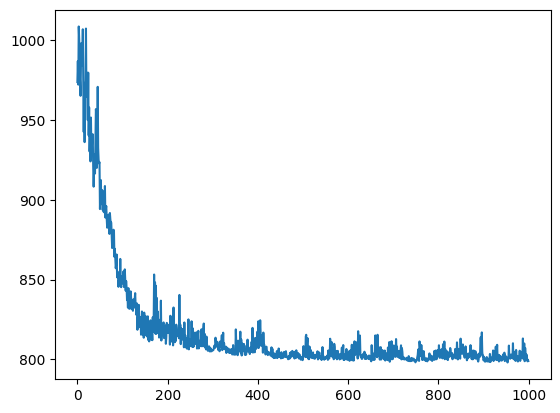

In [10]:
batch_plots(batch_loss_dict)

Done


tensor([[[ 5.7942e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -2.6073e-05,  9.3026e-01],
         [ 5.4692e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.7453e-04,  1.1606e-03],
         [ 5.4204e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -1.3321e-03, -9.6451e-04],
         ...,
         [ 5.4552e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -9.5154e-03, -8.7359e-26],
         [ 5.6242e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.1890e-03,  1.1311e-26],
         [ 5.3623e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.2645e-04,  3.1076e-27]],

        [[ 6.5323e-02,  0.0000e+00, -5.3490e-04,  ...,  9.3571e-07,
          -8.0627e-06, -5.8797e-16],
         [ 5.2457e-02,  0.0000e+00,  1.6011e-02,  ..., -2.7770e-05,
           2.3929e-04,  1.7450e-14],
         [ 5.6398e-02,  0.0000e+00,  9.2794e-01,  ...,  3.9801e-04,
          -3.4305e-03, -2.5010e-13],
         ...,
         [ 6.0586e-02,  0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



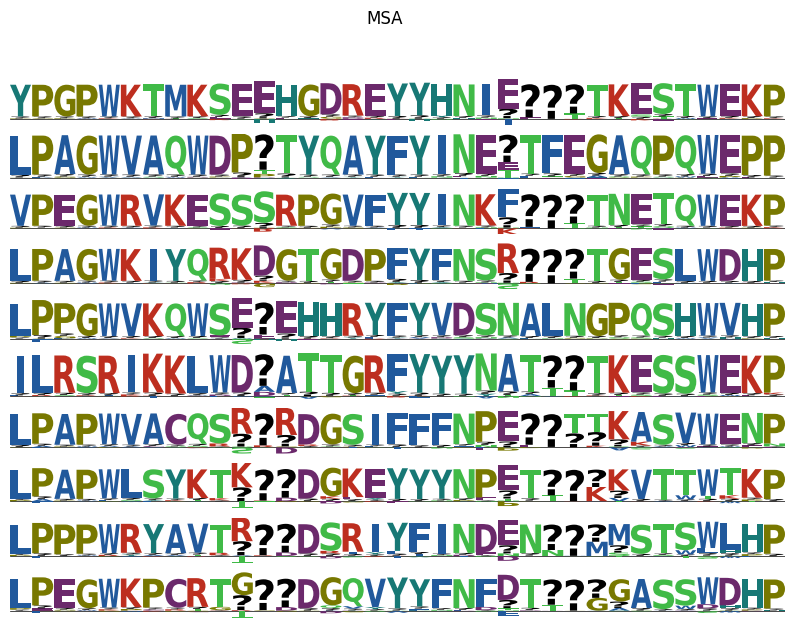

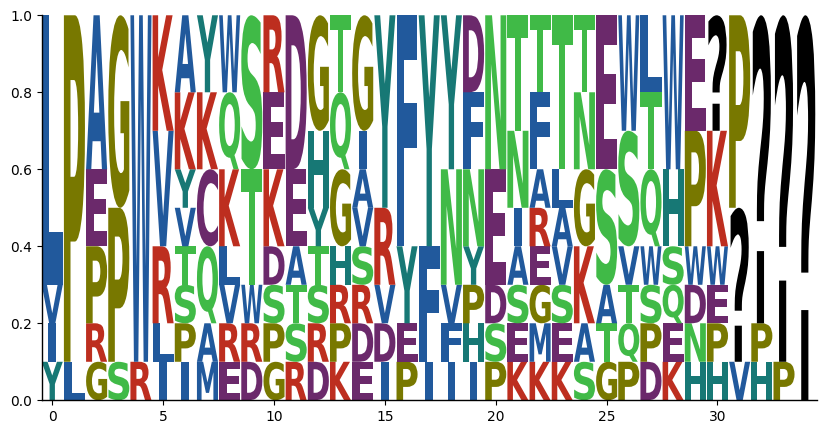

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



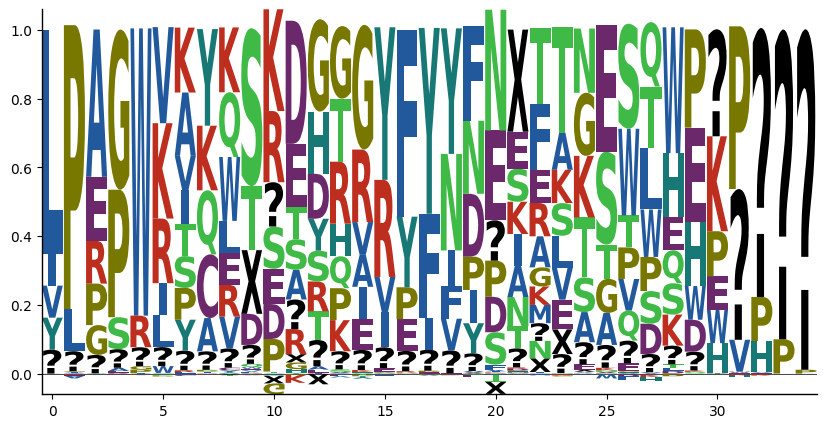

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



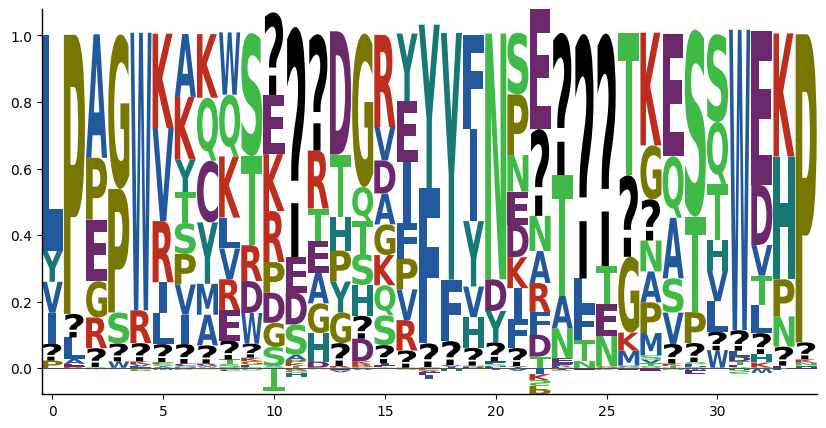

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



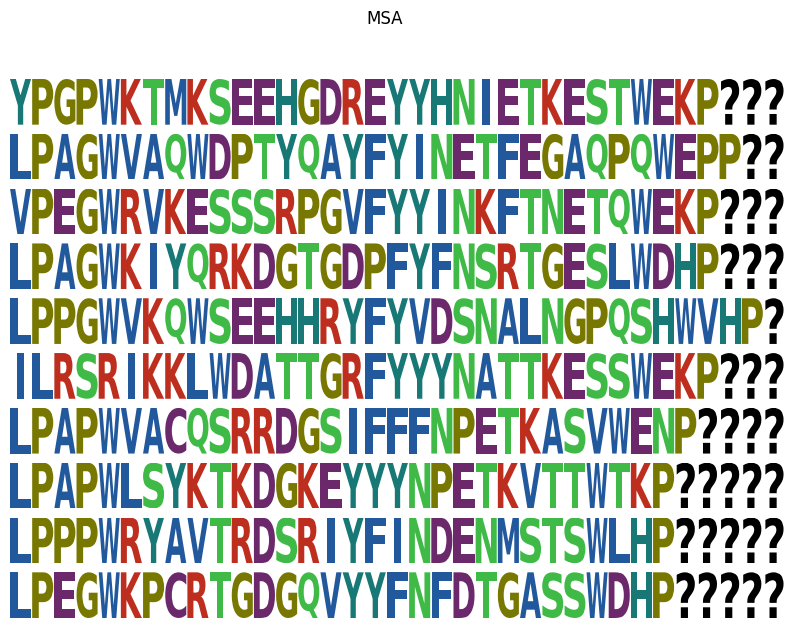

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):


    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq)
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq.to('cpu'), dataset_msa.prot_space.detach().cpu())



RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()